In [1]:
import jax
import jax.numpy as np
import astropy
from astropy.io import fits
from jax import vmap, grad, jit, random
import numpy as onp
import matplotlib.pyplot as plt
import pysynphot as S
import time
from tqdm.notebook import tqdm

import morphine
import morphine_model
import matplotlib as mpl
from jax.config import config
config.update("jax_enable_x64", True)

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.spatial.distance import cdist

In [17]:
pscale = 0.156
num_pix = 2000
pdiam2 = 0.13

In [18]:
def connect(positions):
    node = positions[0,:]
    x = node[0]
    y = node[1]
    length = np.shape(positions)[0]
    dist_array = [0,0,0,0,0]
    # dist, x1, y1, x2, y2
    for i in range(length-1):
        xi = positions[i+1,0]
        yi = positions[i+1,1]
        
        distance = np.sqrt((x-xi)**2 + (y-yi)**2)
        arr = [distance, x, y, xi, yi]
        dist_array = onp.vstack((dist_array, arr))
        
    dist_array = dist_array[1:,:]
    return dist_array

def get_anchorpoints(image, neighborhood_size = 7, threshold = 0.25):
    
    data = image/onp.max(image)
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        
    X = onp.array(x).reshape(-1,1)
    Y = onp.array(y).reshape(-1,1)

    positions = onp.hstack((X, Y))
    
    com_coords = onp.array([0,0])
            # y, x ?
        
    entered = False
    for i in range(np.shape(positions)[0]):
        entered = True
        window = 6  #seems optimal to not overlap with other features
        lowx = int(positions[i,1] - window)
        highx = int(positions[i,1] + window)

        lowy = int(positions[i,0] - window)
        highy = int(positions[i,0] + window)

        com = onp.array([ndimage.center_of_mass(image[lowx:highx+1, lowy:highy+1])])
        com = com[0]
        com[1] = com[1] + lowx
        com[0] = com[0] + lowy
        com_coords = onp.vstack((com_coords, com))
        
    dist_array = [0,0,0,0,0]

    if entered == False:
        print('Error: No anchors found - bad params')
        a = onp.random.randint(low = 50, high = 999999)
        b = onp.random.randint(low = 50, high = 999999)
        com_coords = onp.array([a,b])
        return [dist_array, com_coords]
        
    com_coords = com_coords[1:,:]

    num_points = onp.shape(positions)[0]


    for i in range(num_points-1):
        addition = connect(com_coords[i:,:])
        dist_array = onp.vstack((dist_array, addition))

    dist_array = dist_array[1:,:]
    
    print('Number of Anchors: ' + str(len(x)))
    #print('Expected number of connections: ' + str(int(len(x)*(len(x)-1)*0.5)))
    #print('Actual number of connections: ' + str(np.shape(dist_array)[0]))
    return [dist_array, com_coords]

def calc_image(pscale):
    toliman_Sidelobes = poppy_model_broken.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.13,
                                    central_wav=central_wav,achromatic_pupil = True,grating_amp=onp.sqrt(0.1), pupil_file = 'fixed_pupil.npy')

    num_pix = 2000
    opsys = poppy.OpticalSystem(npix = num_pix)
    opsys.add_pupil(toliman_Sidelobes)
    wf = opsys.input_wavefront()
    opsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 

    PSF = opsys5.calc_psf(source={'wavelengths':wavs,'weights':weights_A})
    PSF = PSF[0].data
    return PSF

def get_just_anchorpoints(image, neighborhood_size = 7, threshold = 0.25, stretch =2):
    
    data = image/onp.max(image)
    data = data**stretch
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        
    X = onp.array(x).reshape(-1,1)
    Y = onp.array(y).reshape(-1,1)

    positions = onp.hstack((X, Y))
    
    com_coords = onp.array([0,0])
            # y, x ?
        
    entered = False
    for i in range(np.shape(positions)[0]):
        entered = True
        window = 6  #seems optimal to not overlap with other features
        lowx = int(positions[i,1] - window)
        highx = int(positions[i,1] + window)

        lowy = int(positions[i,0] - window)
        highy = int(positions[i,0] + window)

        com = onp.array([ndimage.center_of_mass(image[lowx:highx+1, lowy:highy+1])])
        com = com[0]
        com[1] = com[1] + lowx
        com[0] = com[0] + lowy
        com_coords = onp.vstack((com_coords, com))
        
    if entered == False:
        print('Error: No anchors found - bad params')
        a = onp.random.randint(low = 50, high = 999999)
        b = onp.random.randint(low = 50, high = 999999)
        com_coords = onp.array([a,b])
        return [dist_array, com_coords]
        
    com_coords = com_coords[1:,:]

    
    #print('Number of Anchors: ' + str(len(x)))
    #print('Expected number of connections: ' + str(int(len(x)*(len(x)-1)*0.5)))
    #print('Actual number of connections: ' + str(np.shape(dist_array)[0]))
    return com_coords

def apply_photon_noise(image, seed = None):
    if seed is not None:
        onp.seed(seed)
    image_noisy = onp.random.poisson(image)
    return image_noisy

def generate_detector_noise(npixels, nimages, standard_deviation, seed=None):
    if seed is not None:
        onp.seed(seed)
    thermal_noise = np.abs(onp.random.normal(0, standard_deviation, [nimages, npixels, npixels]))
    if nimages == 1:
        return thermal_noise[0]
    return thermal_noise

/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
<ipython-input-4-cf62825da7ac>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12,8))


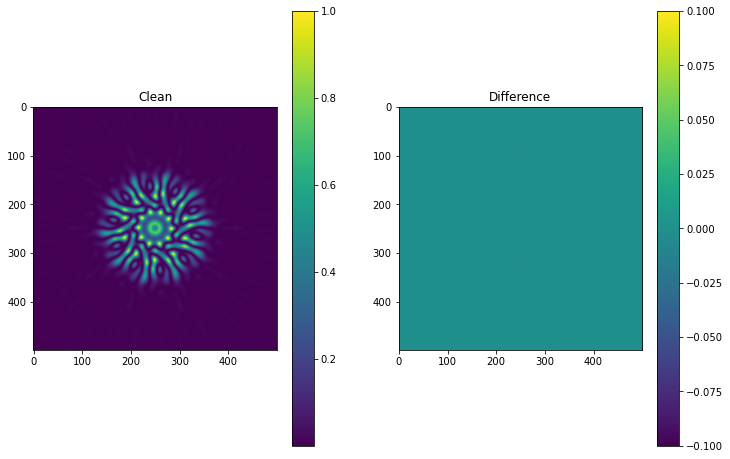

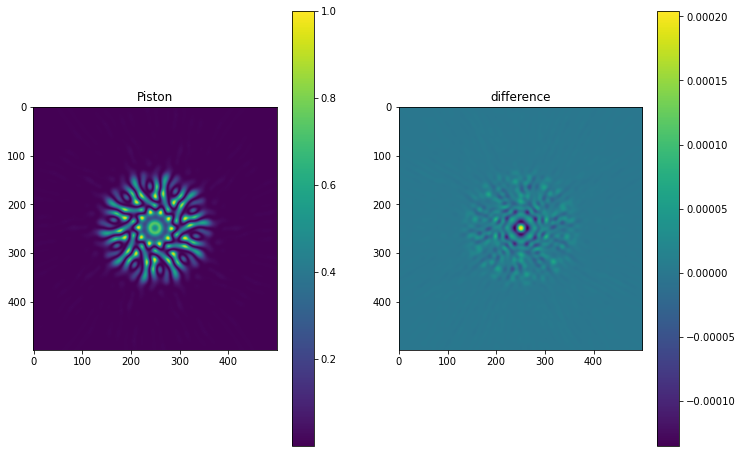

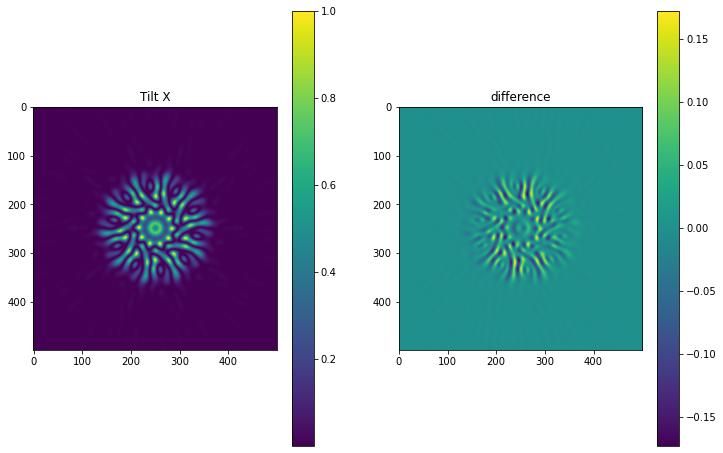

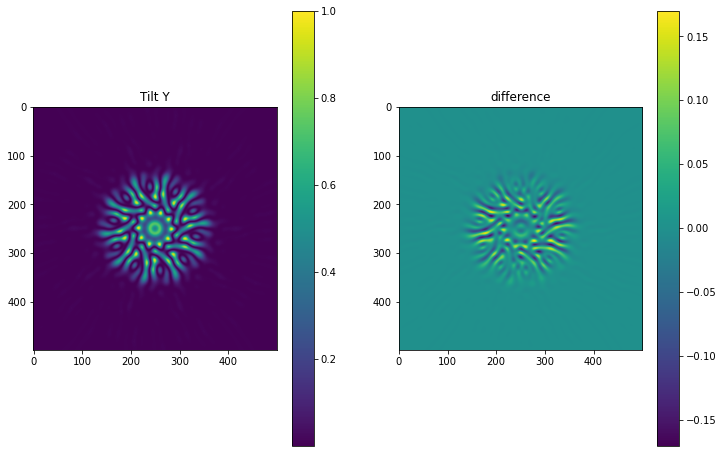

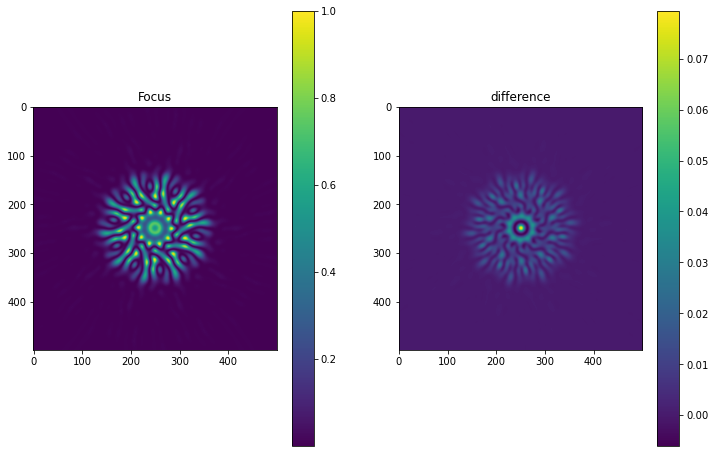

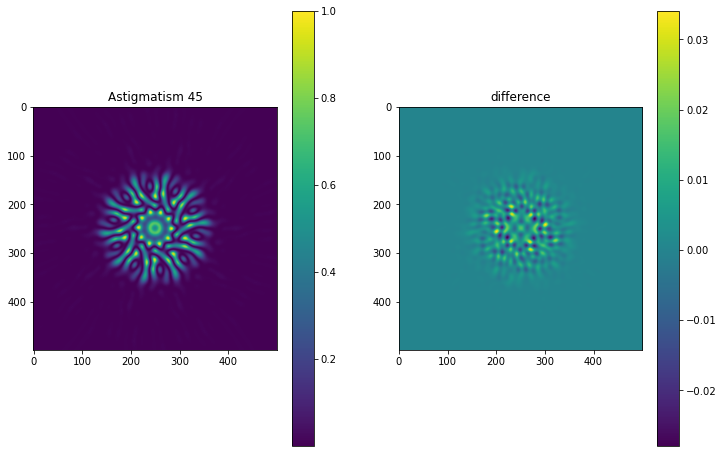

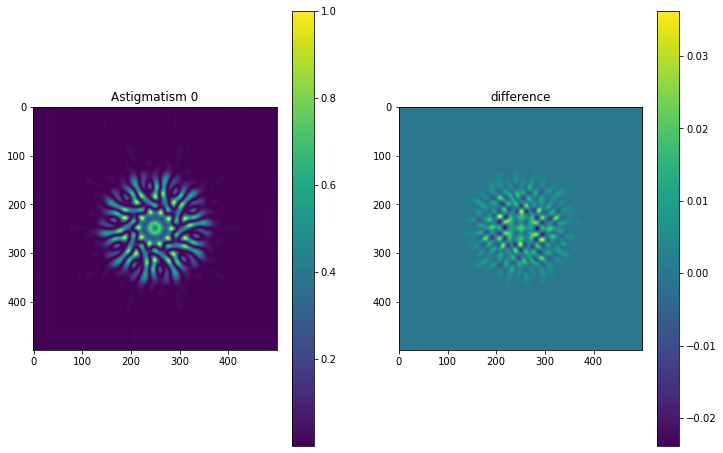

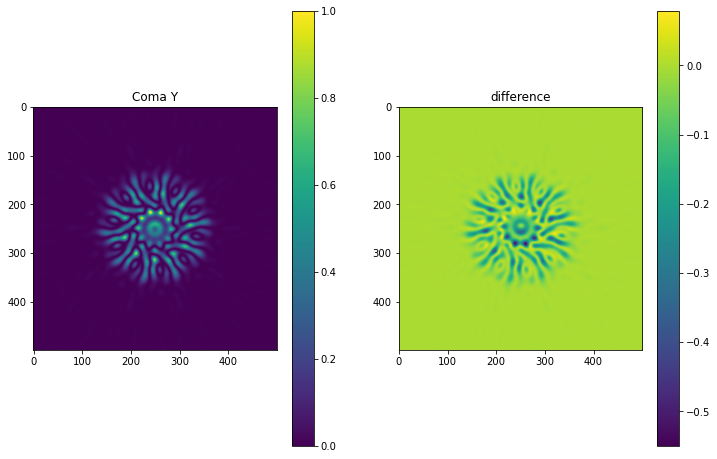

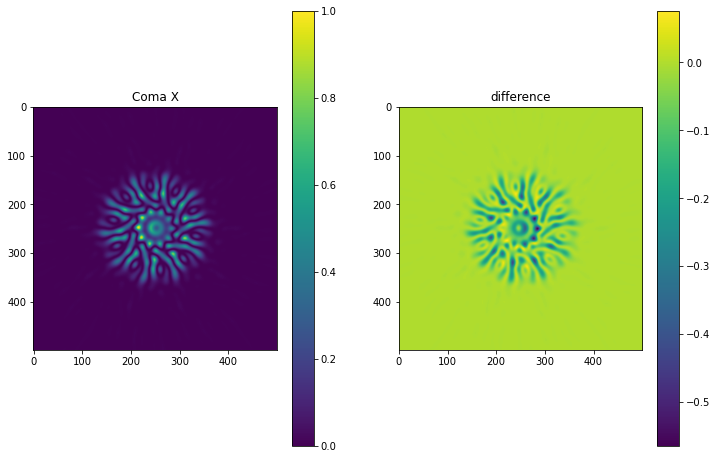

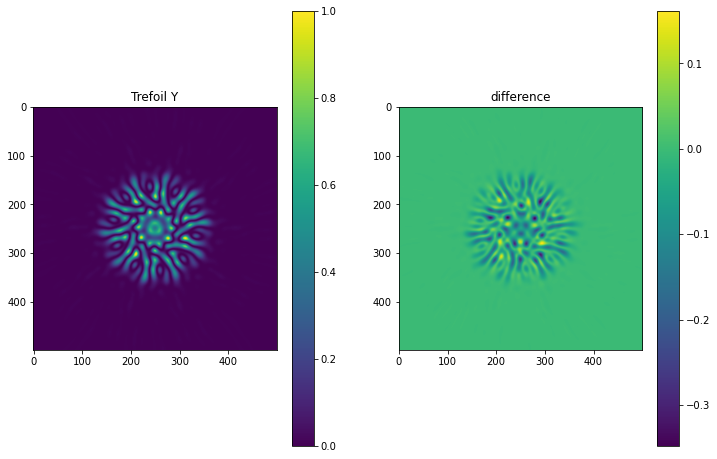

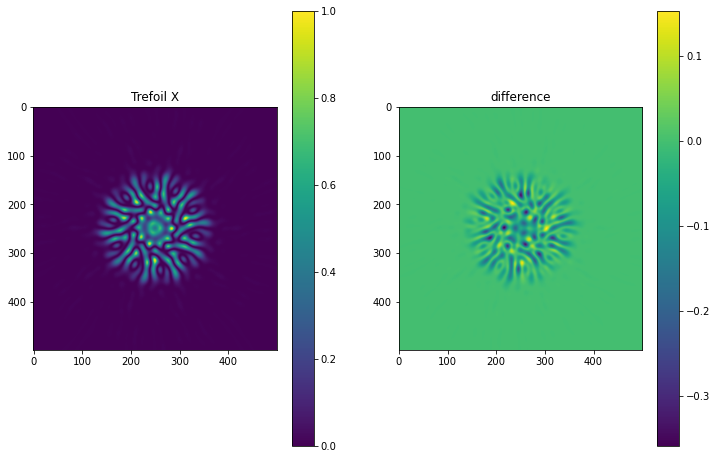

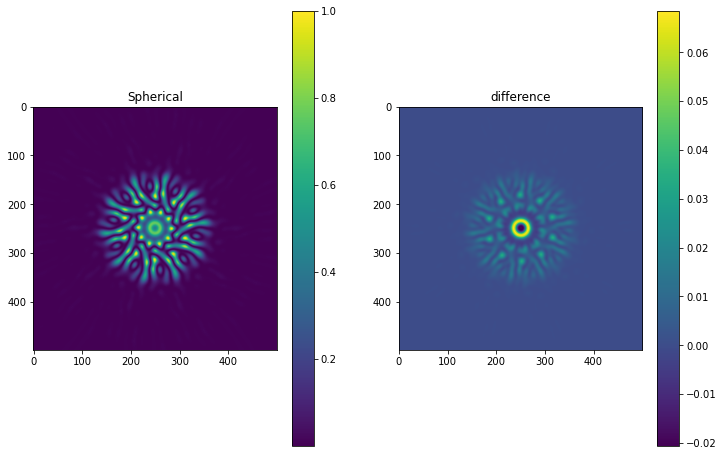

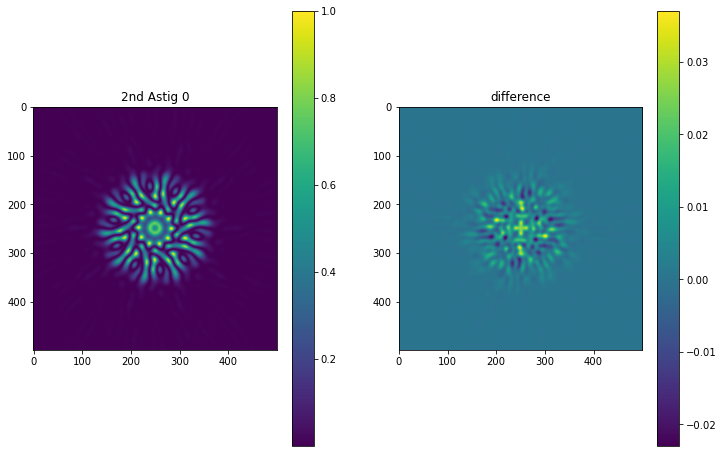

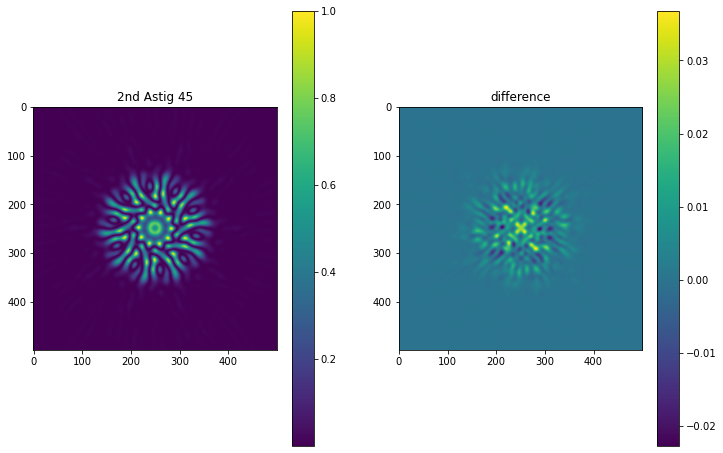

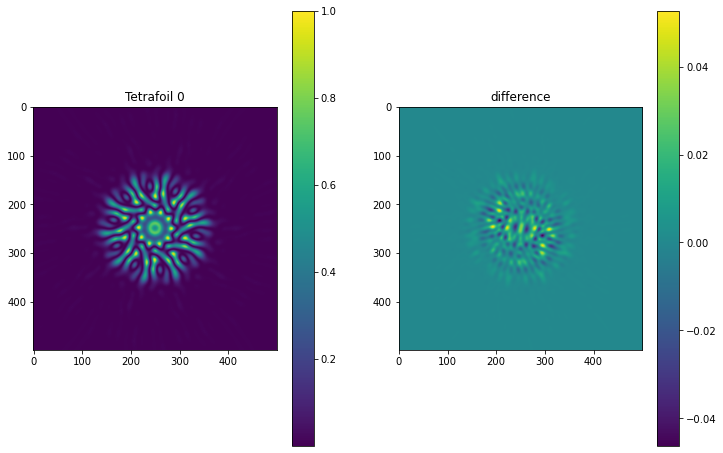

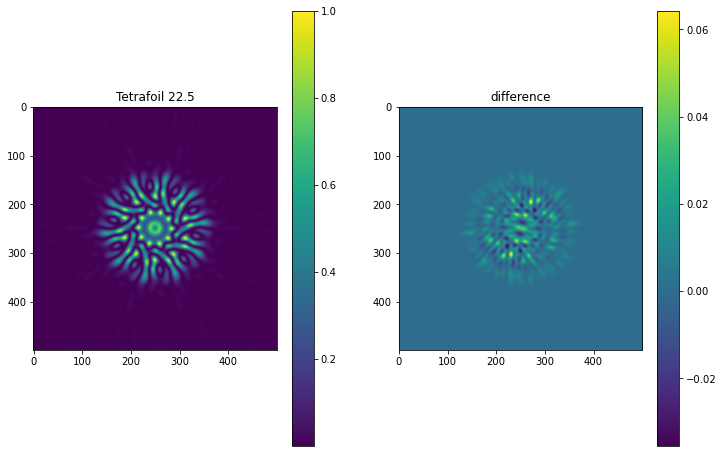

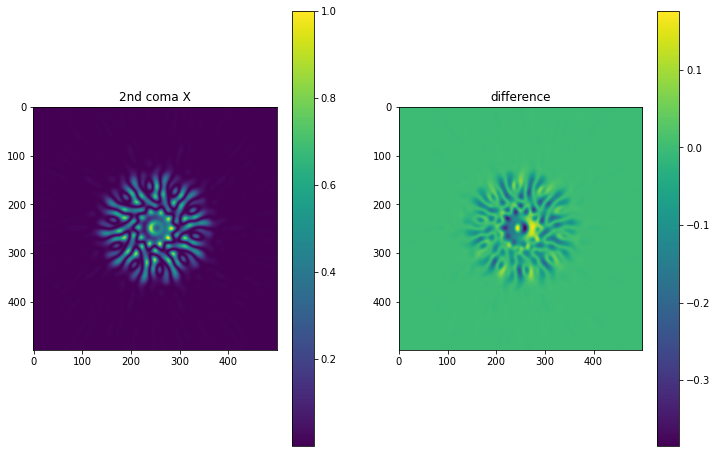

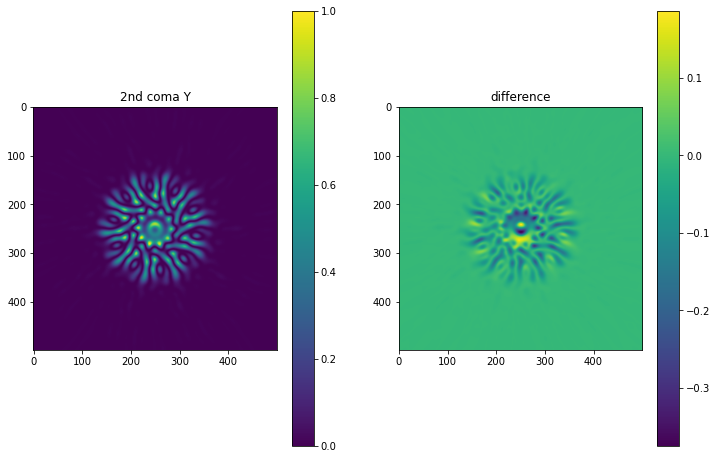

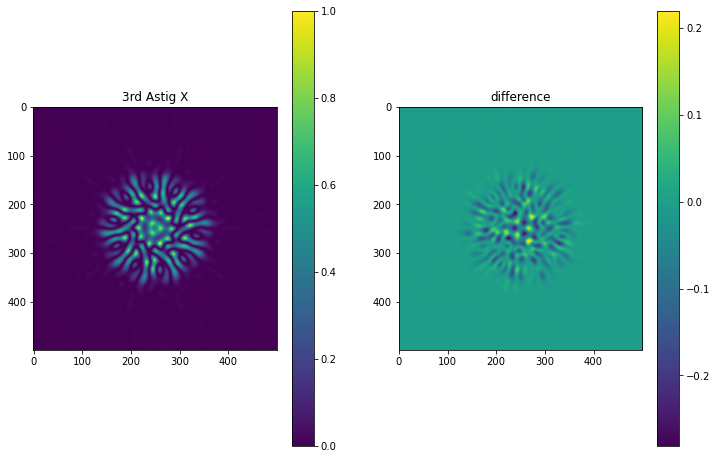

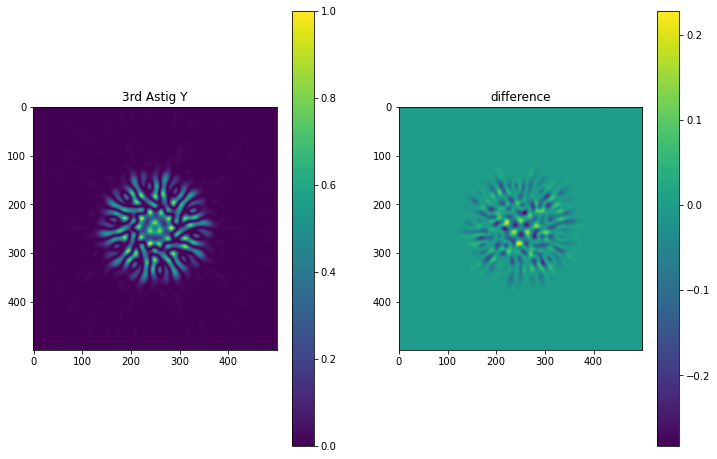

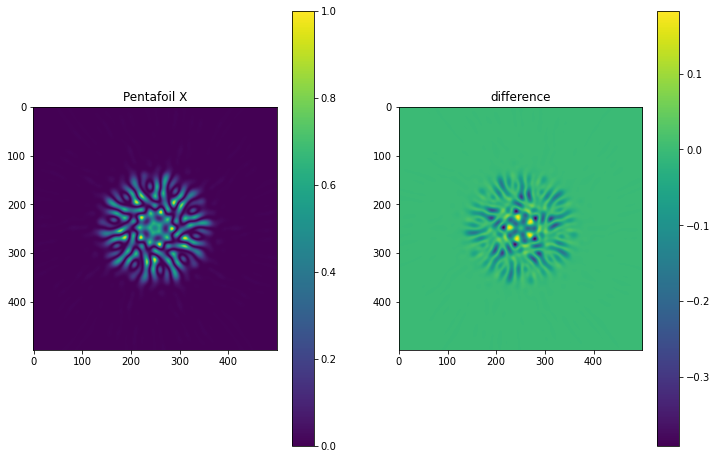

In [4]:
path = 'Sidelobe_fit/sims/Errors_13cm/'

#

clean = onp.load(path+'Clean/0nm.npy')
clean_crop = clean[750:1250,750:1250]/np.max(clean[750:1250,750:1250])


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
plt.imshow(clean_crop)
plt.title('Clean')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Difference')
plt.imshow(clean_crop - clean_crop)
plt.colorbar()



for i in range(20):
    plt.figure(figsize = (12,8))
    image = onp.load(path+'{}/12nm.npy'.format(morphine.zernike.zern_name(i+1)))
    im_crop = image[750:1250,750:1250]/np.max(image[750:1250,750:1250])
        
    plt.subplot(1,2,1)
    plt.imshow(im_crop)
    plt.title(morphine.zernike.zern_name(i+1))
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.imshow(im_crop - clean_crop)
    plt.title('difference')
    plt.colorbar()
    


In [5]:
grid = onp.arange(165,336 ,5)
print(grid)

[165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250
 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335]


For Piston:
    Number of anchors: 50
    There are the same amount of anchors


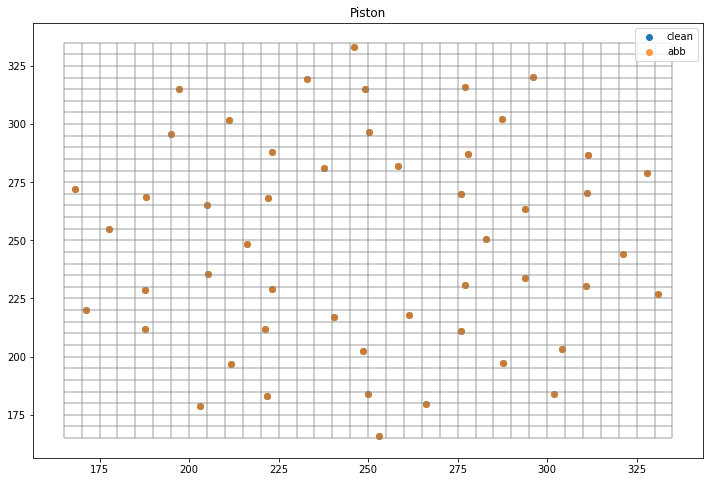

For Tilt X:
    Number of anchors: 50
    There are the same amount of anchors


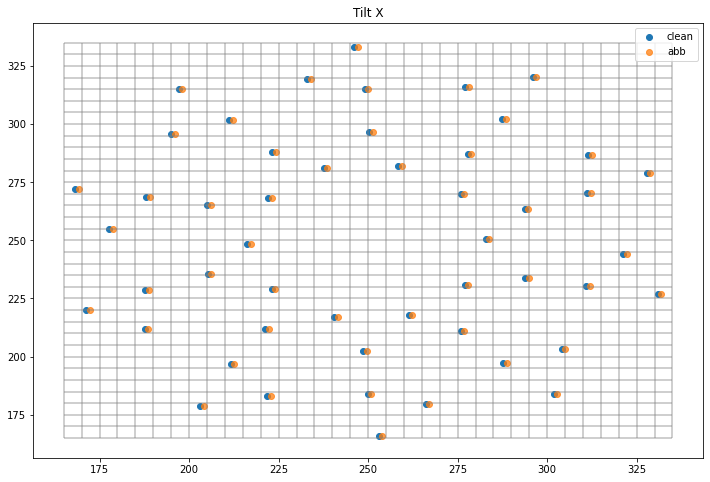

For Tilt Y:
    Number of anchors: 50
    There are the same amount of anchors


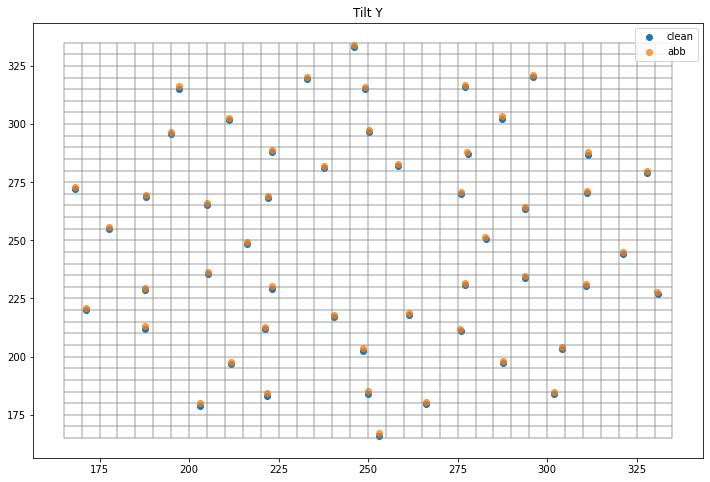

For Focus:
    Number of anchors: 50
    There are the same amount of anchors


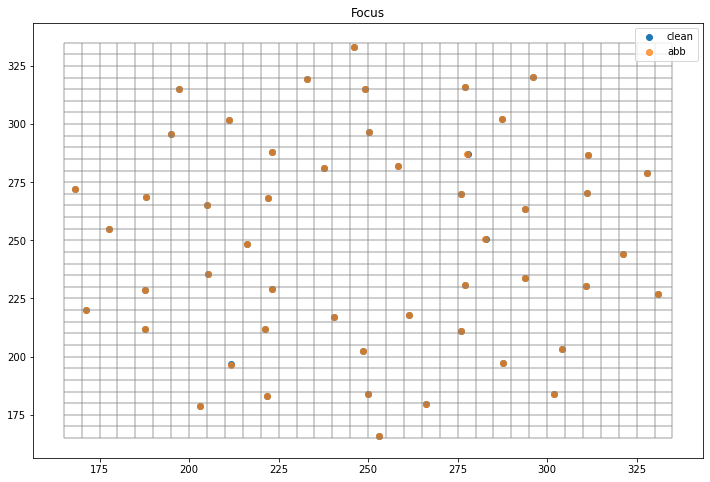

For Astigmatism 45:
    Number of anchors: 50
    There are the same amount of anchors


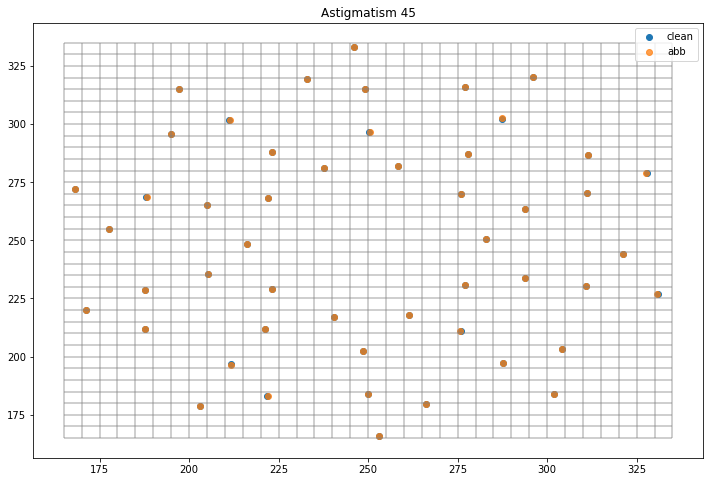

For Astigmatism 0:
    Number of anchors: 50
    There are the same amount of anchors


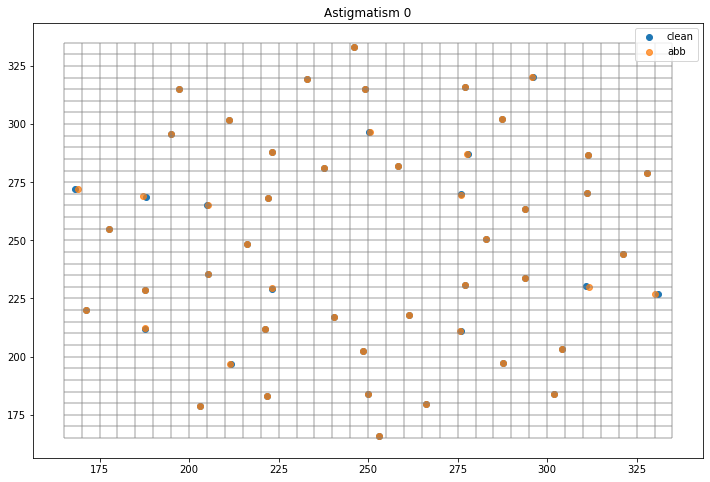

For Coma Y:
    Number of anchors: 24
    There are 26 less anchors


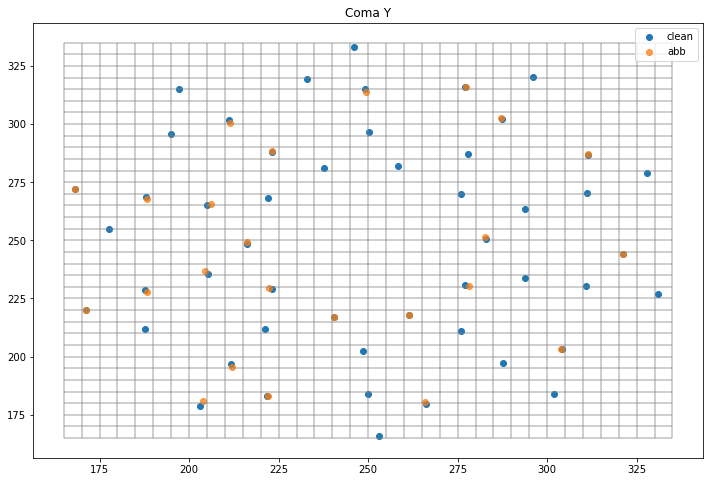

For Coma X:
    Number of anchors: 23
    There are 27 less anchors


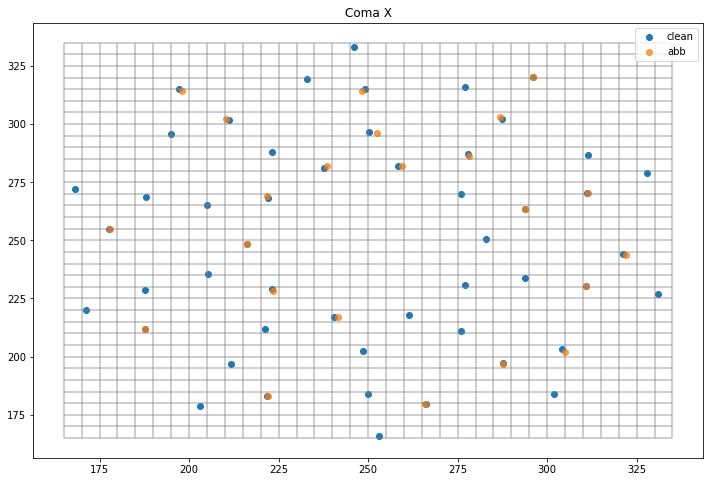

For Trefoil Y:
    Number of anchors: 40
    There are 10 less anchors


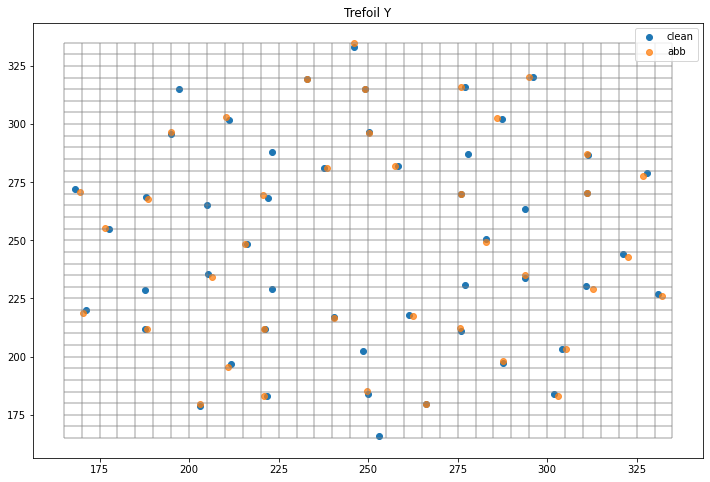

For Trefoil X:
    Number of anchors: 44
    There are 6 less anchors


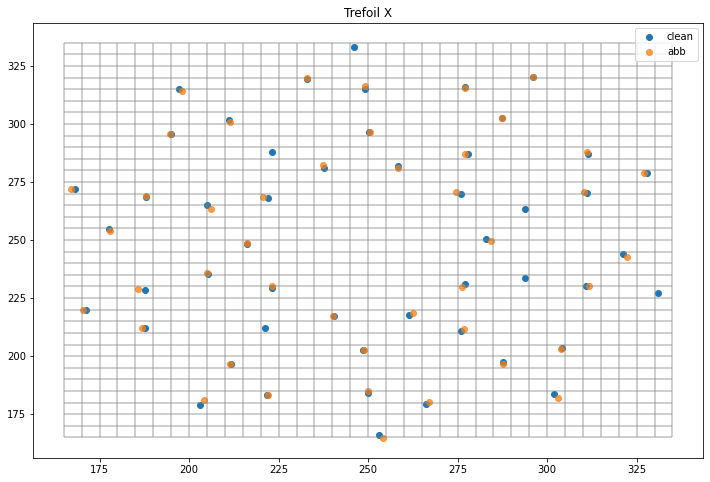

For Spherical:
    Number of anchors: 56
    There are 6 more anchors


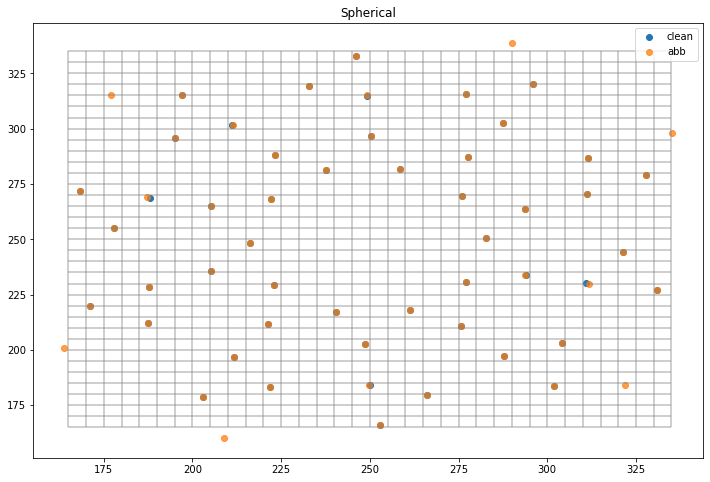

For 2nd Astig 0:
    Number of anchors: 52
    There are 2 more anchors


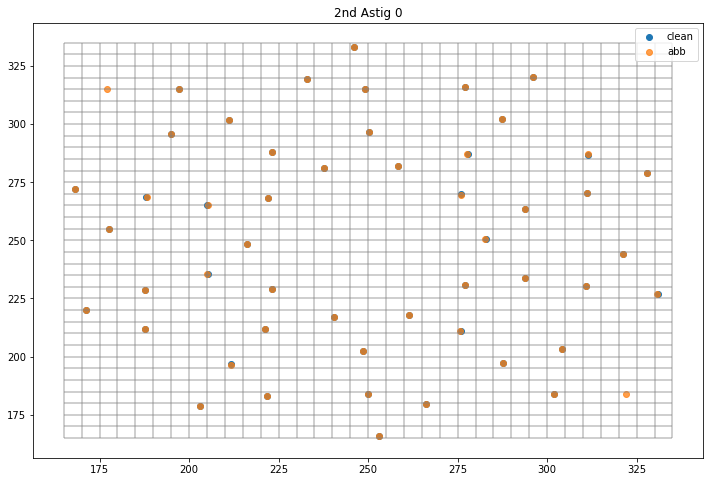

For 2nd Astig 45:
    Number of anchors: 50
    There are the same amount of anchors


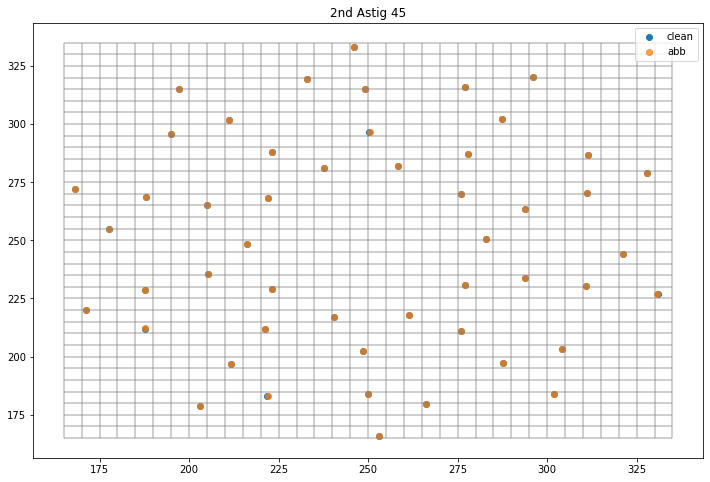

For Tetrafoil 0:
    Number of anchors: 50
    There are the same amount of anchors


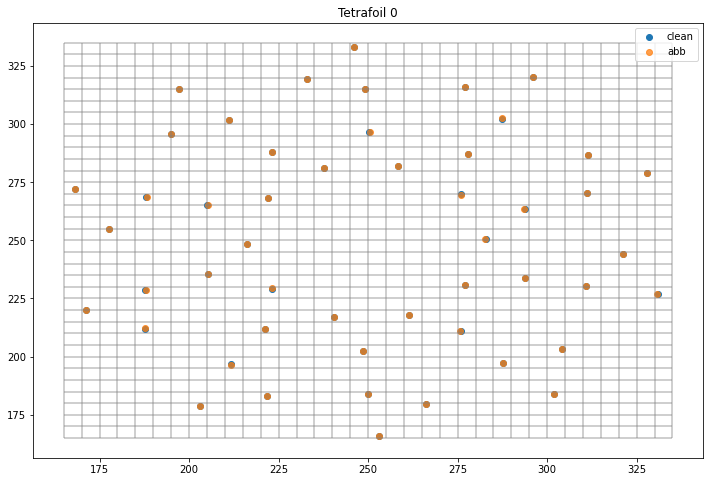

For Tetrafoil 22.5:
    Number of anchors: 52
    There are 2 more anchors


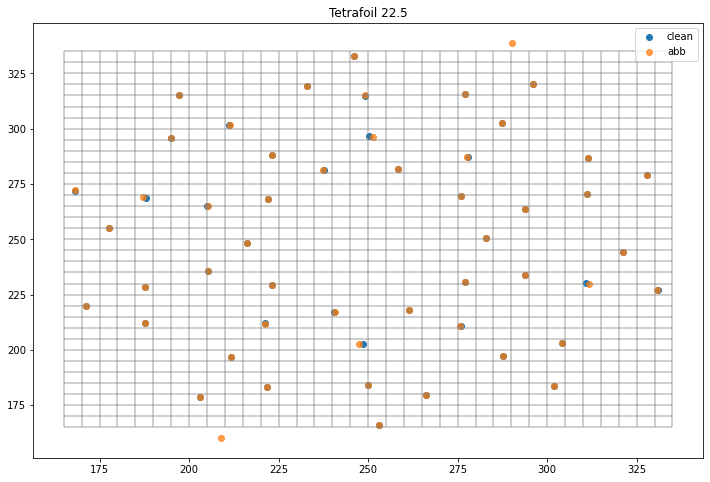

For 2nd coma X:
    Number of anchors: 45
    There are 5 less anchors


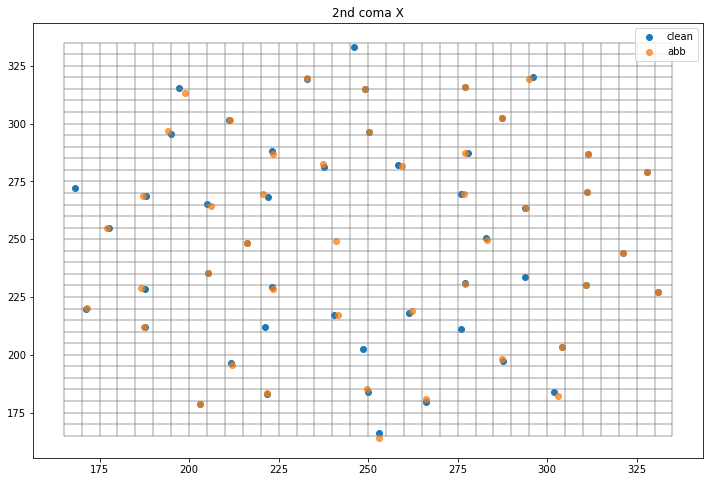

For 2nd coma Y:
    Number of anchors: 45
    There are 5 less anchors


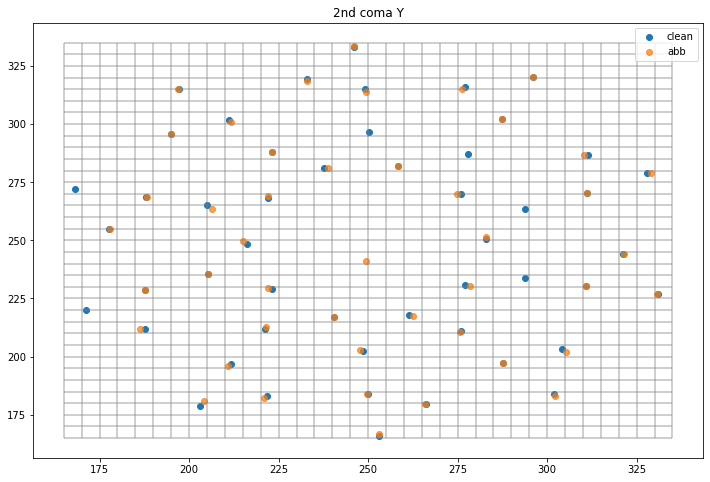

For 3rd Astig X:
    Number of anchors: 49
    There are 1 less anchors


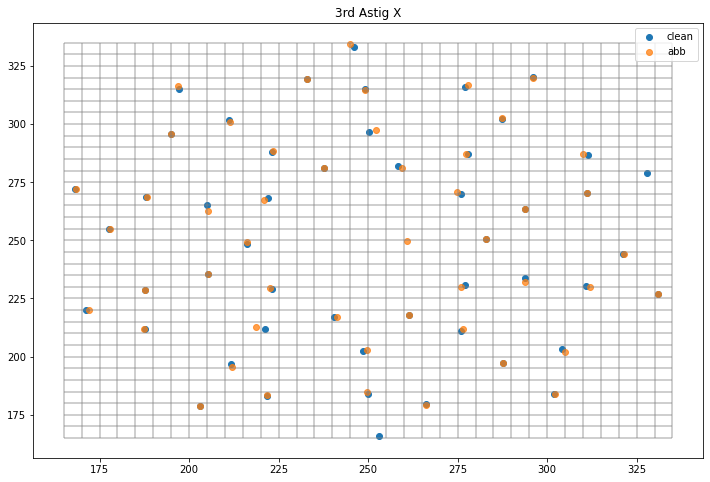

For 3rd Astig Y:
    Number of anchors: 51
    There are 1 more anchors


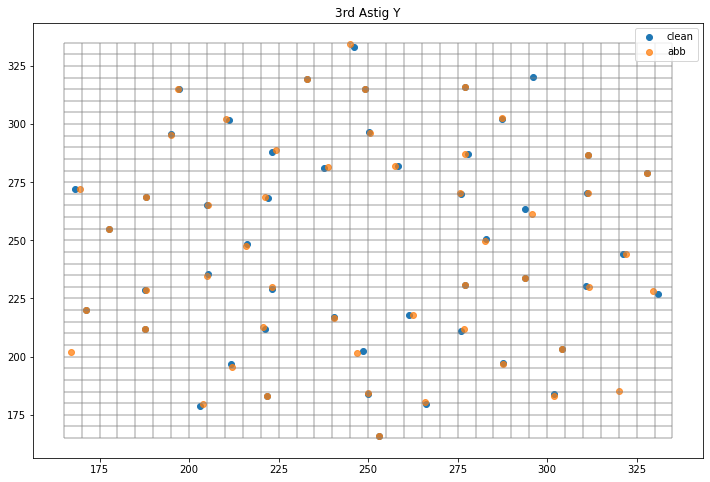

For Pentafoil X:
    Number of anchors: 44
    There are 6 less anchors


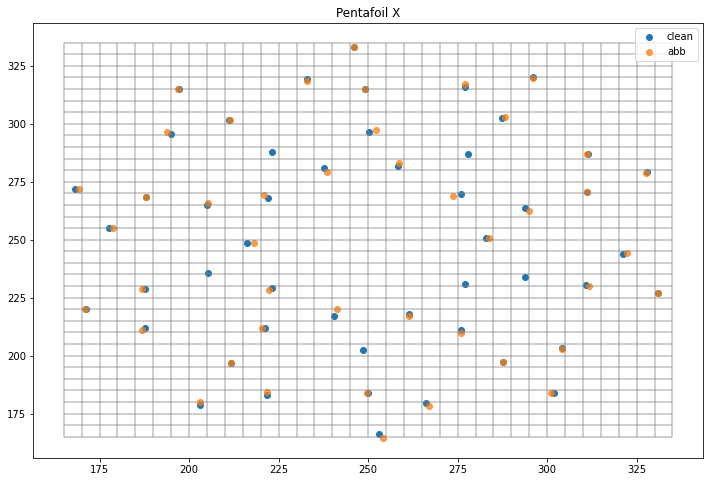

In [6]:
path = 'Sidelobe_fit/sims/Errors_13cm/'

#

clean = onp.load(path+'Clean/0nm.npy')
clean_crop = clean[750:1250,750:1250]/onp.max(clean[750:1250,750:1250])
clean_anchors = get_just_anchorpoints(clean_crop, 7, 0.25)


for i in range(20):
    plt.figure(figsize = (12,8))
    image = onp.load(path+'{}/12nm.npy'.format(morphine.zernike.zern_name(i+1)))
    im_crop = image[750:1250,750:1250]/onp.max(image[750:1250,750:1250])
    abb_anchors = get_just_anchorpoints(im_crop, 7, 0.25)
    
    plt.title(morphine.zernike.zern_name(i+1))
    plt.scatter(clean_anchors[:,0], clean_anchors[:,1], label = 'clean')
    plt.scatter(abb_anchors[:,0], abb_anchors[:,1], label = 'abb', alpha = 0.75)
    plt.vlines(grid, 165, 335, color = 'gray', alpha = 0.5)
    plt.hlines(grid, 165, 335, color = 'gray', alpha = 0.5)

    plt.legend()
    
    print('For '+ str(morphine.zernike.zern_name(i+1)) + ':')
    print('    Number of anchors: ' + str(onp.shape(abb_anchors)[0]))
    if onp.shape(abb_anchors)[0] > onp.shape(clean_anchors)[0]:
        diff = onp.shape(abb_anchors)[0] - onp.shape(clean_anchors)[0]
        print('    There are ' + str(diff) + ' more anchors')
    if onp.shape(abb_anchors)[0] < onp.shape(clean_anchors)[0]:
        diff = onp.shape(abb_anchors)[0] - onp.shape(clean_anchors)[0]
        print('    There are ' + str(-diff) + ' less anchors')
    if onp.shape(abb_anchors)[0] == onp.shape(clean_anchors)[0]:
        print('    There are the same amount of anchors')
    plt.show()





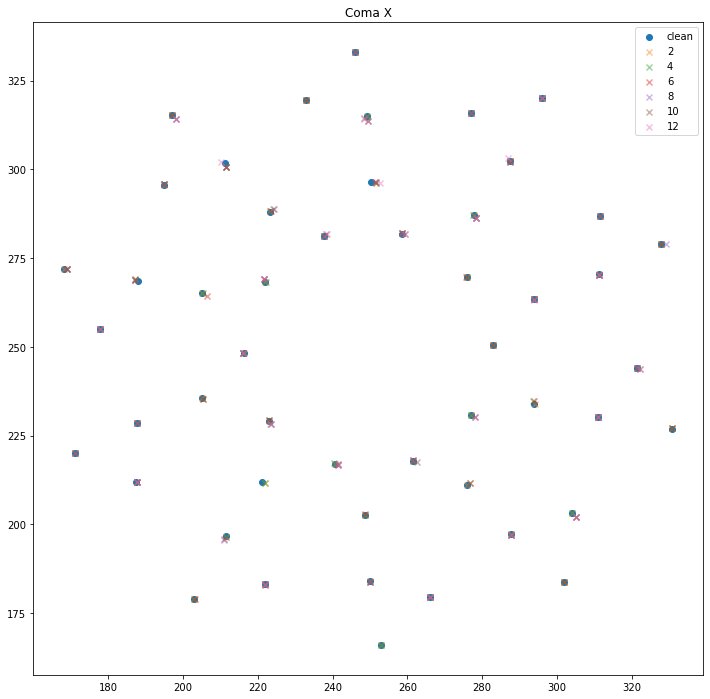

In [7]:
path = 'Sidelobe_fit/sims/Errors_13cm/'

#

clean = onp.load(path+'Clean/0nm.npy')
clean_crop = clean[750:1250,750:1250]/onp.max(clean[750:1250,750:1250])
clean_anchors = get_just_anchorpoints(clean_crop)

plt.figure(figsize = (12,12))
plt.scatter(clean_anchors[:,0], clean_anchors[:,1], label = 'clean')

for i in range(6):
    image = onp.load(path+'Coma X/{}nm.npy'.format(2*i+2))
    im_crop = image[750:1250,750:1250]/onp.max(image[750:1250,750:1250])
    abb_anchors = get_just_anchorpoints(im_crop)
    
    plt.title('Coma X')
    plt.scatter(abb_anchors[:,0], abb_anchors[:,1], label = '{}'.format(2*i+2), alpha = 0.45, marker = 'x')
    plt.legend()


In [19]:
def get_stable_anchors(full_image, neighborhood_size = 7, threshold = 0.25, stretch = 2, flux = 1e10, iterations = 5):
    #input must be the full image (2000,2000)
    #returns anchors that are roughly in the area of the clean anchors
    
    image_centre = full_image[750:1250,750:1250]/onp.max(full_image[750:1250,750:1250])
    
    clean_anchors = get_just_anchorpoints(image_centre, neighborhood_size, threshold, stretch)
    num_anchors = onp.shape(clean_anchors)[0]
    
    X_positions = onp.zeros((num_anchors + 10, iterations+1))
    Y_positions = onp.zeros((num_anchors + 10, iterations+1))
    
    X_positions[:num_anchors,0] = clean_anchors[:,0]
    Y_positions[:num_anchors,0] = clean_anchors[:,1]

    for i in range(iterations):
        dark_current = 2 # electrons
        PSF_photons = apply_photon_noise(flux * full_image)
        detector_noise = generate_detector_noise(num_pix, 1, dark_current)
        noisy_PSF = PSF_photons + detector_noise
        noisy_PSF = onp.asarray(noisy_PSF)
        noisy_centre = noisy_PSF[750:1250,750:1250]/onp.max(noisy_PSF[750:1250,750:1250])
        
        noisy_anchors = get_just_anchorpoints(noisy_centre, neighborhood_size, threshold, stretch)
        
        for j in range(onp.shape(noisy_anchors)[0]):
                dist = onp.sqrt((clean_anchors[:,0] - noisy_anchors[j,0])**2 + (clean_anchors[:,1] - noisy_anchors[j,1])**2)
                closest = onp.argwhere(dist == onp.min(dist))[0]
                
                if dist[closest] < 2:
                    X_positions[closest, i+1] = noisy_anchors[j,0]
                    Y_positions[closest, i+1] = noisy_anchors[j,1]
                    
                    
    New_X = onp.zeros((1,iterations+1))   
    New_Y = onp.zeros((1,iterations+1))               

    for i in range(onp.shape(X_positions)[0]):
        check = np.any(X_positions[i] == 0)
        if check == False:
            New_X = onp.vstack((New_X, X_positions[i]))
            New_Y = onp.vstack((New_Y, Y_positions[i]))

    New_X = New_X[1:,:]
    New_Y = New_Y[1:,:]

    return New_X, New_Y

    
    

In [20]:
xx, yy = get_stable_anchors(clean, iterations = 10, flux = 1e8)
print(len(xx))
print(len(yy))

NameError: name 'clean' is not defined

  0%|          | 0/13 [00:00<?, ?it/s]

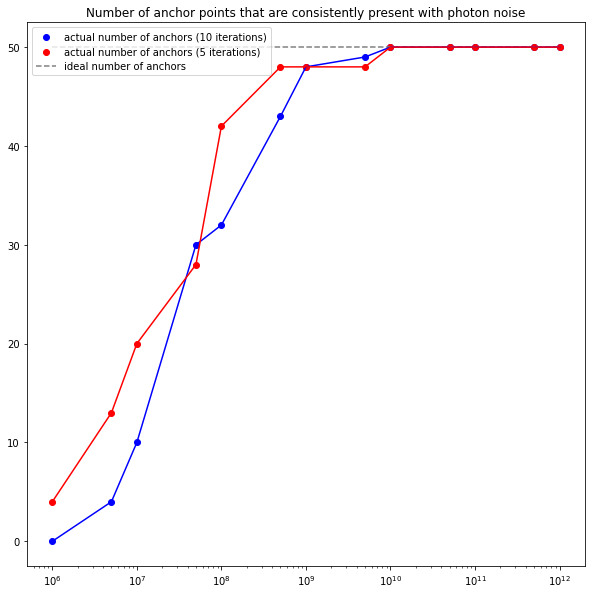

In [10]:
fluxes = [1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12]

num_anchors = onp.array([])
num_anchors2 = onp.array([])
true_num_anchors = onp.shape(get_just_anchorpoints(clean[750:1250,750:1250]))[0]

for i in tqdm(range(len(fluxes))):
    xx,yy = get_stable_anchors(clean, iterations = 10, flux = fluxes[i])
    num_anchors = onp.append(num_anchors, len(xx))
    
    xx,yy = get_stable_anchors(clean, iterations = 5, flux = fluxes[i])
    num_anchors2 = onp.append(num_anchors2, len(xx))
    
plt.figure(figsize = (10,10))
plt.scatter(fluxes, num_anchors, label = 'actual number of anchors (10 iterations)', color = 'blue')
plt.plot(fluxes, num_anchors, color = 'blue')
plt.scatter(fluxes, num_anchors2, label = 'actual number of anchors (5 iterations)', color = 'red')
plt.plot(fluxes, num_anchors2, color = 'red')
plt.hlines(true_num_anchors, 1e6, 1e12, ls = '--', color = 'grey', label = 'ideal number of anchors')
plt.xscale('log')
plt.title('Number of anchor points that are consistently present with photon noise')
plt.legend()

In [47]:
def get_really_stable_anchors(full_image, neighborhood_size = 7, threshold = 0.25, stretch = 2, flux = 1e9*60*60, iterations = 10):
    #input must be the full image (2000,2000)
    #returns anchors that are very close to clean anchors
    num_pix = 512
    #image_centre = full_image[750:1250,750:1250]/onp.max(full_image[750:1250,750:1250])
    image_centre = full_image
    
    clean_anchors = get_just_anchorpoints(image_centre, neighborhood_size, threshold, stretch)
    num_anchors = onp.shape(clean_anchors)[0]
    
    X_positions = onp.zeros((num_anchors + 10, iterations+1))
    Y_positions = onp.zeros((num_anchors + 10, iterations+1))
    
    X_positions[:num_anchors,0] = clean_anchors[:,0]
    Y_positions[:num_anchors,0] = clean_anchors[:,1]

    for i in range(iterations):
        # adds photon noise and dark current
        dark_current = 2 # electrons
        PSF_photons = apply_photon_noise(flux * image_centre)
        detector_noise = generate_detector_noise(num_pix, 1, dark_current)
        noisy_PSF = PSF_photons + detector_noise
        noisy_PSF = onp.asarray(noisy_PSF)
        #noisy_centre = noisy_PSF[750:1250,750:1250]/onp.max(noisy_PSF[750:1250,750:1250])
        noisy_centre = noisy_PSF/onp.max(noisy_PSF)
        
        noisy_anchors = get_just_anchorpoints(noisy_centre, neighborhood_size, threshold, stretch)
        
        for j in range(onp.shape(noisy_anchors)[0]):
            # ensures we are comparing the same anchorpoints by finding distance between them. Could probably be optimised idk
                dist = onp.sqrt((clean_anchors[:,0] - noisy_anchors[j,0])**2 + (clean_anchors[:,1] - noisy_anchors[j,1])**2)
                closest = onp.argwhere(dist == onp.min(dist))[0]
                
                if dist[closest] < 2:
                    X_positions[closest, i+1] = noisy_anchors[j,0]
                    Y_positions[closest, i+1] = noisy_anchors[j,1]
                    
                    
    New_X = onp.zeros((1,iterations+1))   
    New_Y = onp.zeros((1,iterations+1))               

    for i in range(onp.shape(X_positions)[0]):
        check = np.any(X_positions[i] == 0)
        
        var1 = onp.std(X_positions[i])
        var2 = onp.std(Y_positions[i])
        av_var = (var1+var2)/2
        
        if check == False and av_var < 0.001:
            New_X = onp.vstack((New_X, X_positions[i]))
            New_Y = onp.vstack((New_Y, Y_positions[i]))

    New_X = New_X[1:,:]
    New_Y = New_Y[1:,:]
    

    return New_X, New_Y
                    
    

In [25]:
def apply_photon_noise(image, seed = None):
    if seed is not None:
        onp.seed(seed)
    image_noisy = onp.random.poisson(image)
    return image_noisy

def generate_detector_noise(npixels, nimages, standard_deviation, seed=None):
    if seed is not None:
        onp.seed(seed)
    thermal_noise = onp.abs(onp.random.normal(0, standard_deviation, [nimages, npixels, npixels]))
    if nimages == 1:
        return thermal_noise[0]
    return thermal_noise

def make_noisy(image, flux):
    dark_current = 2 # electrons
    PSF_photons = apply_photon_noise(flux * image)#, seed = seed)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)#, seed = seed)
    noisy_PSF = PSF_photons + detector_noise
    noisy_PSF = noisy_PSF/onp.max(noisy_PSF)
    return noisy_PSF

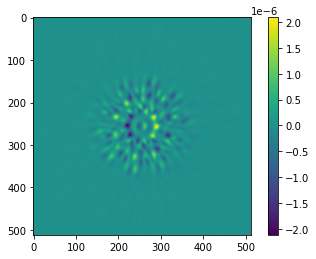

In [11]:
image = onp.load('20wavsPSFs/Zernikes 1psf/Coma X/0nm.npy')
image1 = onp.load('20wavsPSFs/Zernikes 1psf/Coma X/1nm.npy')
plt.imshow(image - image1)
plt.colorbar()

56
1.9354723685489696e-05
2.2978384145259347e-05
1.907900482523031e-05
1.9685495423755394e-05
1.9319148007283396e-05
1.61747795534612e-05
1.9966765977400707e-05
1.273633483106119e-05
1.1910404208012875e-05
1.2970279380380807e-05
2.3699577387479358e-05
1.2784157212432073e-05
1.9832311653020423e-05
2.3898199676069828e-05
8.950457064770286e-06
2.067943913313195e-05
1.625435398322517e-05
1.5992242230022125e-05
2.593897222715916e-05
2.201058025704781e-05
1.4429921932956804e-05
1.8506655109989973e-05
1.62769826488535e-05
1.5521639063700978e-05
1.9590581380142284e-05
2.1679947372919036e-05
1.97070413345984e-05
1.6288101994788e-05
2.451116120158026e-05
1.8568879345410167e-05
1.6975343211122533e-05
1.5432490049815062e-05
1.9940227664068623e-05
2.2062649658323824e-05
2.9176687198858585e-05
2.547909614288288e-05
1.562871773285551e-05
9.511792866674978e-06
2.0136667567175497e-05
2.770404425295699e-05
1.892321693111978e-05
1.2623277315208502e-05
2.0667661242368756e-05
1.7204098624853523e-05
1.41679

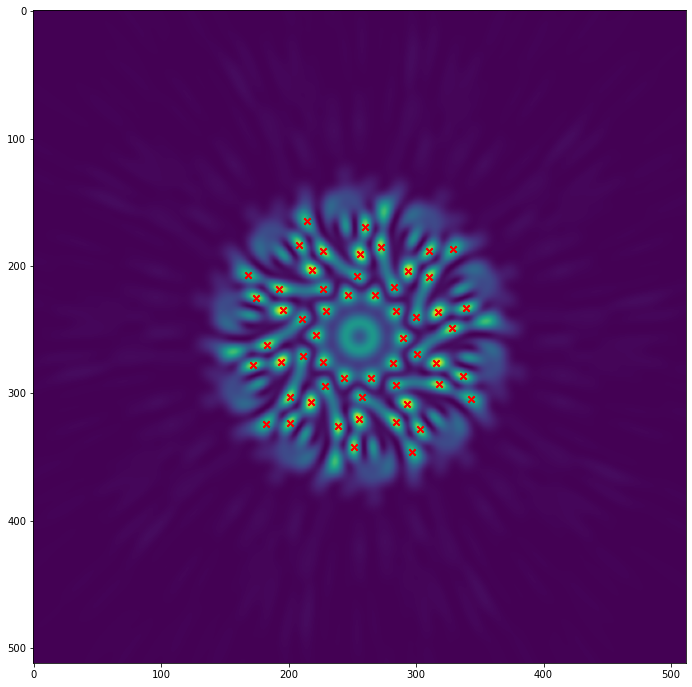

In [25]:
%%time
xx,yy = get_really_stable_anchors(image)
plt.figure(figsize = (12,12))
plt.scatter(xx,yy,marker = 'x',  color = 'red')
plt.imshow(image)
print(len(xx))
#print(xx[:,0])
for i in range(len(xx)):
    print(np.std(xx[i,:]))

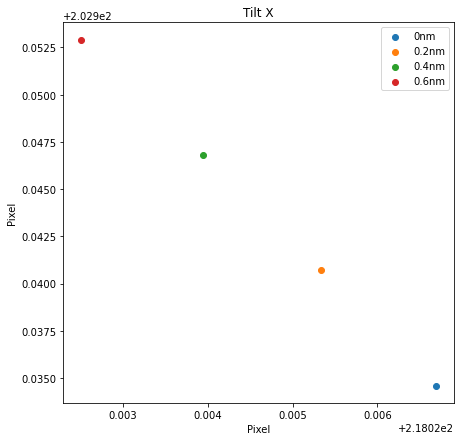

In [29]:
for i in range(1):
    i = 1
    plt.figure(figsize = (7,7))
    name = morphine.zernike.zern_name(i+1)
    
    image1 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0nm.npy'.format(name))
    image2 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.2nm.npy'.format(name))
    image3 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.4nm.npy'.format(name))
    image4 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.6nm.npy'.format(name))
    #image5 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.8nm.npy'.format(name))

    
    xx1,yy1 = get_really_stable_anchors(image1)
    xx2,yy2 = get_really_stable_anchors(image2)
    xx3,yy3 = get_really_stable_anchors(image3)
    xx4,yy4 = get_really_stable_anchors(image4)
    #xx5,yy5 = get_really_stable_anchors(image5)

    
    #plt.scatter(xx2-xx1,yy2-yy1,marker = 'x')
    k = 8
    plt.scatter(xx1[k,:],yy1[k,:], label = '0nm')
    plt.scatter(xx2[k,:],yy2[k,:], label = '0.2nm')
    plt.scatter(xx3[k,:],yy3[k,:], label = '0.4nm')
    plt.scatter(xx4[k,:],yy4[k,:], label = '0.6nm')
    #plt.scatter(xx5[k,:],yy5[k,:], label = '1.6nm')
    plt.ylabel('Pixel')
    plt.xlabel('Pixel')
    plt.title(name)
    plt.legend()

  0%|          | 0/4 [00:00<?, ?it/s]

(array([-0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

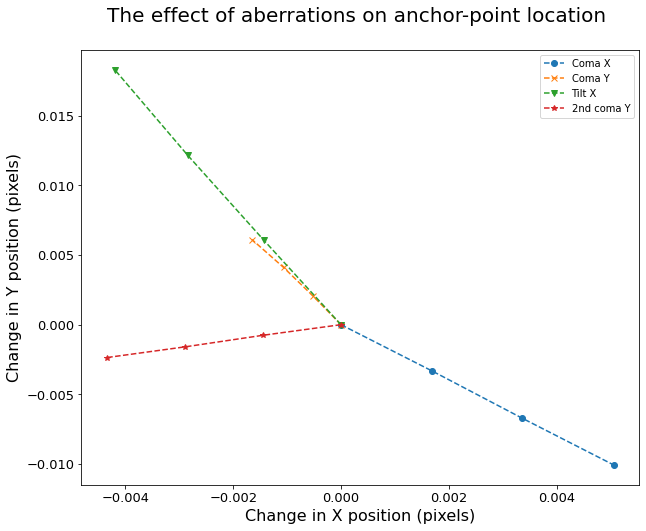

In [49]:
plt.figure(figsize = (10,8))
zerns = ['Coma X', 'Coma Y', 'Tilt X', '2nd coma Y']
mags = ['0', '0.2', '0.4', '0.6']
ls = ['--o', '--x', '--v', '--*', '--^']
for i in tqdm(range(len(zerns))):
    locs_x = onp.array([])
    locs_y = onp.array([])
    for j in range(len(mags)):
        image = onp.load('20wavsPSFs/Zernikes 1psf/{}/{}nm.npy'.format(zerns[i], mags[j]))
        x,y = get_really_stable_anchors(image)
        
        k = 8
        locs_x = onp.append(locs_x, x[k,1])
        locs_y = onp.append(locs_y, y[k,1])
    plt.plot(locs_x-locs_x[0],locs_y-locs_y[0], '{}'.format(ls[i]), label = zerns[i])

plt.legend()
plt.xlabel('Change in X position (pixels)', fontsize = 16)
plt.ylabel('Change in Y position (pixels)', fontsize = 16)
plt.title('The effect of aberrations on anchor-point location \n', fontsize = 20)    
plt.xticks(fontsize =13)
plt.yticks(fontsize =13)

    

NameError: name 'jnp' is not defined

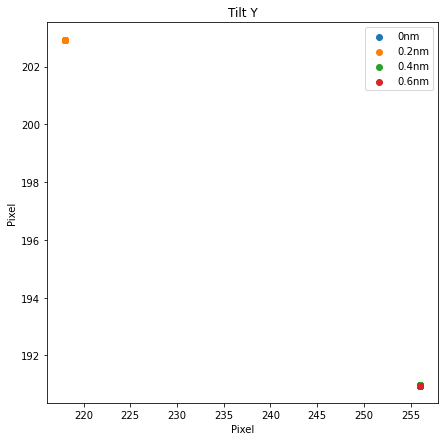

In [73]:
for i in range(1):
    i = 2
    plt.figure(figsize = (7,7))
    name = morphine.zernike.zern_name(i+1)
    
    image1 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0nm.npy'.format(name))
    image2 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.2nm.npy'.format(name))
    image3 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.4nm.npy'.format(name))
    image4 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.6nm.npy'.format(name))
    #image5 = onp.load('20wavsPSFs/Zernikes 1psf/{}/0.8nm.npy'.format(name))

    
    xx1,yy1 = get_really_stable_anchors(image1)
    xx2,yy2 = get_really_stable_anchors(image2)
    xx3,yy3 = get_really_stable_anchors(image3)
    xx4,yy4 = get_really_stable_anchors(image4)
    #xx5,yy5 = get_really_stable_anchors(image5)

    
    #plt.scatter(xx2-xx1,yy2-yy1,marker = 'x')
    k = 8
    plt.scatter(xx1[k,:],yy1[k,:], label = '0nm')
    plt.scatter(xx2[k,:],yy2[k,:], label = '0.2nm')
    plt.scatter(xx3[k,:],yy3[k,:], label = '0.4nm')
    plt.scatter(xx4[k,:],yy4[k,:], label = '0.6nm')
    #plt.scatter(xx5[k,:],yy5[k,:], label = '1.6nm')
    plt.ylabel('Pixel')
    plt.xlabel('Pixel')
    plt.title(name)
    plt.legend()

In [ ]:
print(stop)

In [13]:
xx,yy = get_really_stable_anchors(clean)

  0%|          | 0/13 [00:00<?, ?it/s]

0
0
0
0
0
0
0
29
38
43
48
49
50


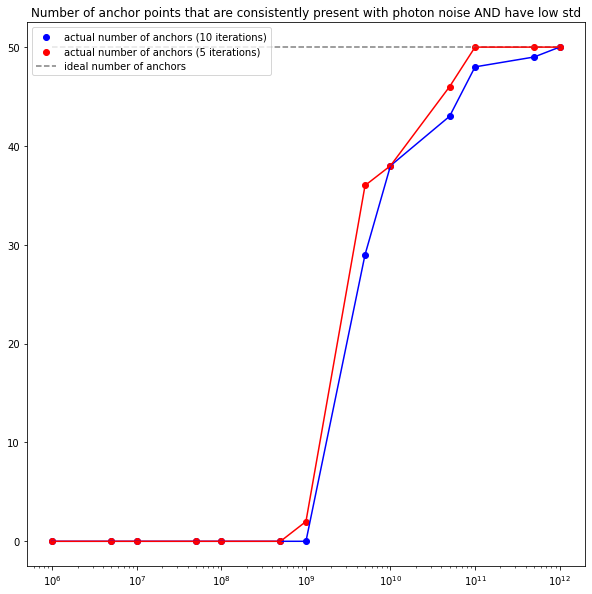

In [14]:
fluxes = [1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e11, 1e12]

num_anchors = onp.array([])
num_anchors2 = onp.array([])
true_num_anchors = onp.shape(get_just_anchorpoints(clean[750:1250,750:1250]))[0]

for i in tqdm(range(len(fluxes))):
    xx,yy = get_really_stable_anchors(clean, iterations = 10, flux = fluxes[i])
    print(len(xx))
    num_anchors = onp.append(num_anchors, len(xx))
    
    xx,yy = get_really_stable_anchors(clean, iterations = 5, flux = fluxes[i])
    num_anchors2 = onp.append(num_anchors2, len(xx))
    
plt.figure(figsize = (10,10))
plt.scatter(fluxes, num_anchors, label = 'actual number of anchors (10 iterations)', color = 'blue')
plt.plot(fluxes, num_anchors, color = 'blue')
plt.scatter(fluxes, num_anchors2, label = 'actual number of anchors (5 iterations)', color = 'red')
plt.plot(fluxes, num_anchors2, color = 'red')
plt.hlines(true_num_anchors, 1e6, 1e12, ls = '--', color = 'grey', label = 'ideal number of anchors')
plt.xscale('log')
plt.title('Number of anchor points that are consistently present with photon noise AND have low std')

plt.legend()

In [27]:
image = onp.load('Sidelobe_fit/sims/Errors_13cm/Coma X/2nm.npy')
true_num_anchors = onp.shape(get_just_anchorpoints(image[750:1250,750:1250]))[0]
print(onp.shape(image))
print(true_num_anchors)

(2000, 2000)
50


10


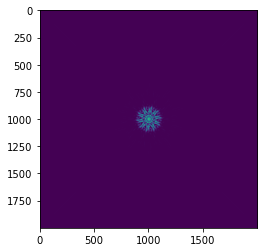

In [42]:
path = 'Sidelobe_fit/sims/Errors_13cm/'
plt.imshow(onp.load(path+'Coma X/2nm.npy'))

xx,yy  = get_really_stable_anchors(image, iterations = 8, flux = 1.8e9)
print(len(xx))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

<Figure size 1440x720 with 0 Axes>

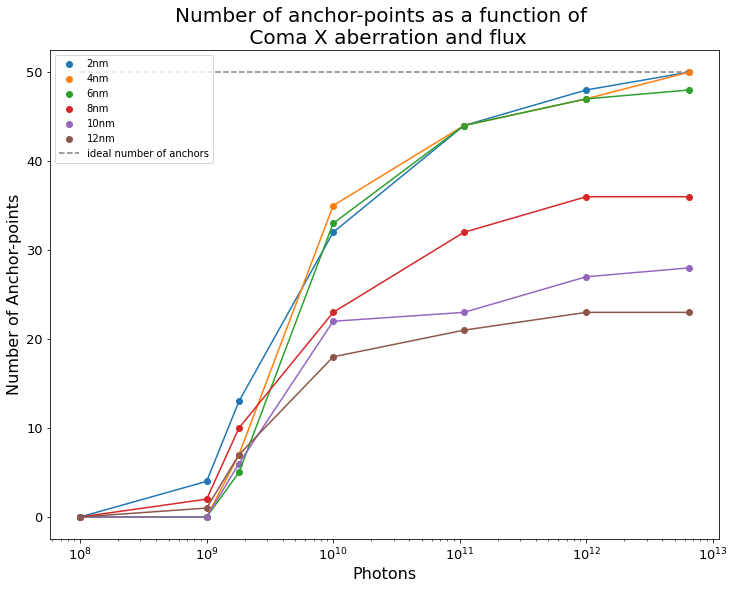

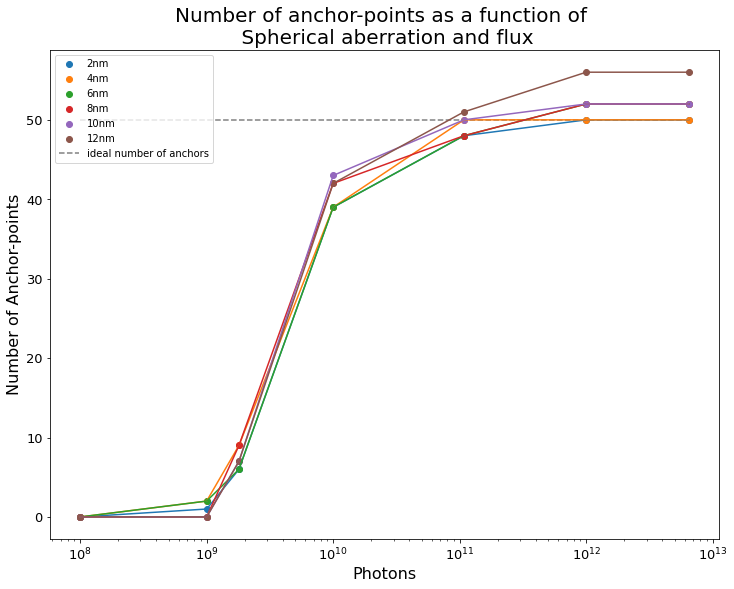

In [45]:
plt.figure(figsize = (20,10))
names = ['Coma X', 'Spherical'] 

for k in range(len(names)):
    plt.figure(figsize = (12,9))

    full_path = path + names[k]
    fluxes = [ 1e8,1e9, 1.8e9, 1e10, 1.08e11, 1e12, 6.48e12]

    for i in tqdm(range(6)):
        abb = '/{}nm.npy'.format(2*i+2)
        image = onp.load(full_path + abb)
        num_anchors = onp.array([])
        for j in tqdm(range(len(fluxes))):
                xx,yy = get_really_stable_anchors(image, iterations = 8, flux = fluxes[j])
                num_anchors = onp.append(num_anchors, len(xx))

        plt.scatter(fluxes, num_anchors, label = '{}nm'.format(2*i+2))
        plt.plot(fluxes, num_anchors)

    plt.hlines(true_num_anchors, 1e8, 6.48e12, ls = '--', color = 'grey', label = 'ideal number of anchors')
    plt.xscale('log')
    plt.title('Number of anchor-points as a function of \n {} aberration and flux'.format(names[k]), fontsize = 20)
    plt.xlabel('Photons', fontsize = 16)
    plt.ylabel('Number of Anchor-points', fontsize = 16)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.legend()   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

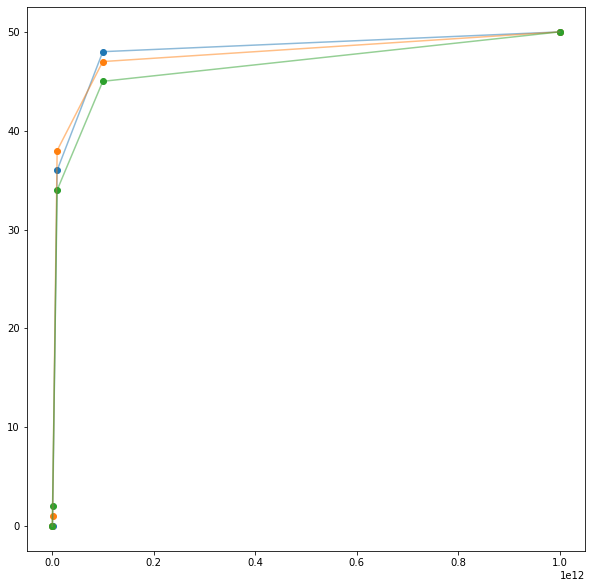

In [17]:
fluxes = [5e8, 1e9,  1e10,  1e11, 1e12]

for zern in tqdm(range(20)):

    plt.figure(figsize = (10,10))
    full_path = path + '{}/'.format(morphine.zernike.zern_name(zern+1))
    for i in tqdm(range(6)):
        abb = '{}nm.npy'.format(2*i+2)
        image = onp.load(full_path + abb)

        num_anchors = onp.array([])
        for j in range(len(fluxes)):
                xx,yy = get_really_stable_anchors(image, iterations = 8, flux = fluxes[j])
                num_anchors = onp.append(num_anchors, len(xx))

        plt.scatter(fluxes, num_anchors, label = '{}nm'.format(2*i+2))
        plt.plot(fluxes, num_anchors, alpha = 0.5)

    plt.hlines(true_num_anchors, 5e8, 1e12, ls = '--', color = 'grey', label = 'ideal number of anchors')
    plt.xscale('log')
    plt.title('Very stable anchor points as a function of aberration and flux')
    plt.xlabel('{}'.format(morphine.zernike.zern_name(zern+1)))
    plt.legend()   
    plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

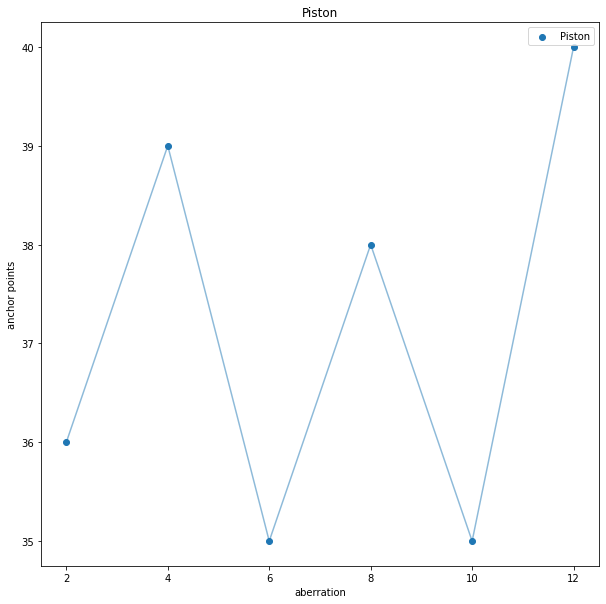

  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [18]:


for zern in tqdm(range(20)):

    plt.figure(figsize = (10,10))
    full_path = path + '{}/'.format(morphine.zernike.zern_name(zern+1))
    num_anchors = onp.array([])

    for i in tqdm(range(6)):
        abb = '{}nm.npy'.format(2*i+2)
        image = onp.load(full_path + abb)

        xx,yy = get_really_stable_anchors(image, iterations = 8, flux = 1e10)
        num_anchors = onp.append(num_anchors, len(xx))

    plt.scatter([2,4,6,8,10,12], num_anchors, label = '{}'.format(morphine.zernike.zern_name(zern+1)))
    plt.plot([2,4,6,8,10,12], num_anchors, alpha = 0.5)

    plt.title('{}'.format(morphine.zernike.zern_name(zern+1)))
    plt.xlabel('aberration')
    plt.ylabel('anchor points')
    plt.legend()   
    plt.show()

In [19]:
clean_image = onp.load('Sidelobe_fit/sims/Errors_13cm/Clean/0nm.npy') 
random1nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/1nm.npy')
random2nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/2nm.npy')
random3nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/3nm.npy')
random4nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/4nm.npy')
random5nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/5nm.npy')
random6nm = onp.load('Sidelobe_fit/sims/Errors_13cm/Random/6nm.npy')


clean_anchors_XX, clean_anchors_YY  = get_really_stable_anchors(clean_image)
random1_anchors_XX, random1_anchors_YY = get_really_stable_anchors(random1nm)
random2_anchors_XX, random2_anchors_YY = get_really_stable_anchors(random2nm)
random3_anchors_XX, random3_anchors_YY = get_really_stable_anchors(random3nm)
random4_anchors_XX, random4_anchors_YY = get_really_stable_anchors(random4nm)
random5_anchors_XX, random5_anchors_YY = get_really_stable_anchors(random5nm)
random6_anchors_XX, random6_anchors_YY = get_really_stable_anchors(random6nm)

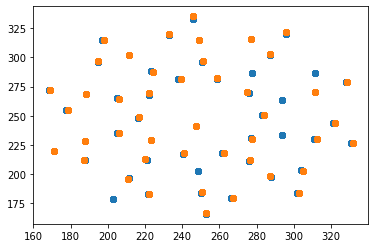

In [20]:
plt.scatter(clean_anchors_XX, clean_anchors_YY)
plt.scatter(random6_anchors_XX, random6_anchors_YY)

In [21]:
clean_anchors_xx, clean_anchors_yy = get_really_stable_anchors(clean_image, iterations = 0)
positions = onp.hstack((clean_anchors_xx, clean_anchors_yy))
positions_noise = onp.hstack((random6_anchors_XX, random6_anchors_YY))
connect_clean = connect(positions)

50


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1225 [00:00<?, ?it/s]

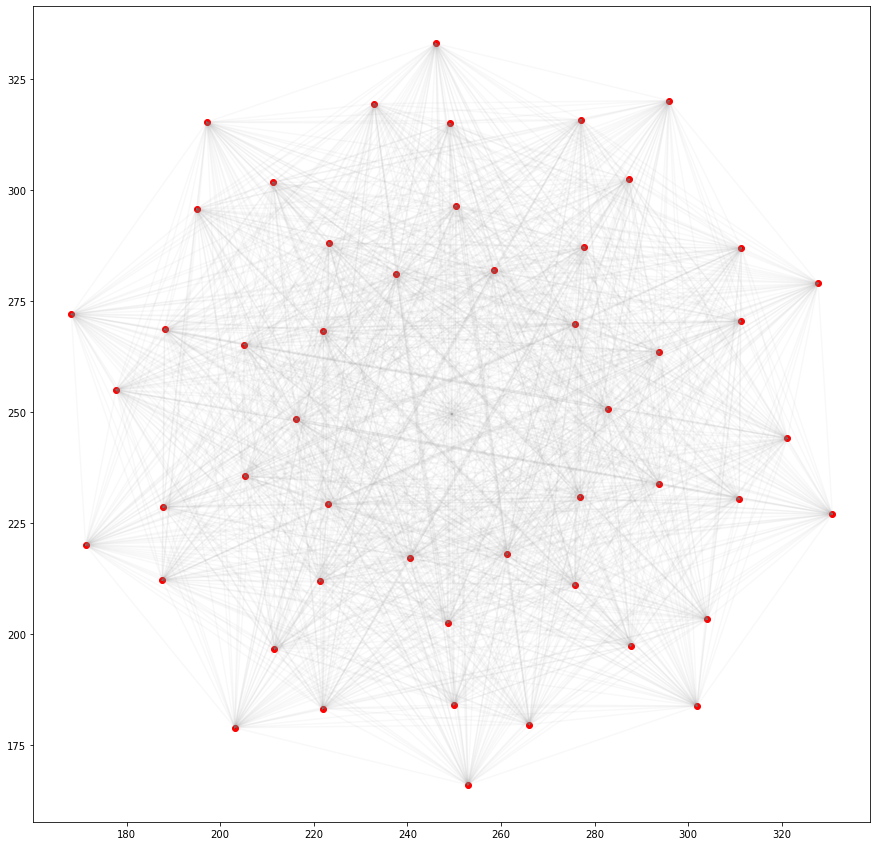

In [22]:
plt.figure(figsize = (15,15))

num_points = onp.shape(positions)[0]
print(num_points)

dist_array = [0,0,0,0,0]

for i in tqdm(range(num_points-1)):
    addition = connect(positions[i:,:])
    dist_array = onp.vstack((dist_array, addition))
    
dist_array = dist_array[1:,:]
for i in tqdm(range(len(dist_array))):
    plt.plot([dist_array[i,1], dist_array[i,3]], [dist_array[i,2], dist_array[i,4]], color = 'grey', alpha = 0.05)
    
plt.scatter(positions[:,0], positions[:,1], color = 'red')



In [ ]:
def make_graph(positions):
    num_points = onp.shape(positions)[0]
    dist_array = [0,0,0,0,0]

    for i in tqdm(range(num_points-1)):
        addition = connect(positions[i:,:])
        dist_array = onp.vstack((dist_array, addition))
    dist_array = dist_array[1:,:]

    #for i in tqdm(range(len(dist_array))):
    #plt.plot([dist_array[i,1], dist_array[i,3]], [dist_array[i,2], dist_array[i,4]], color = 'grey', alpha = 0.05)
    #plt.scatter(positions[:,0], positions[:,1], color = 'red')
    return dist_array

## fix this
def trim_anchors(list1, list2):
    if len(list1) == len(list2):
        print('Arrays are same size!')
        return list1, list2
    if len(list1) < len(list2):
        short_list = list1
        long_list = list2
        
        flip = False
    if len(list1) > len(list2):
        short_list = list2
        long_list = list1
        
        flip = True
     
    num_anchors = len(long_list)
    print(len(short_list))
    print(len(long_list))
        
    X_positions = onp.zeros(num_anchors)
    Y_positions = onp.zeros(num_anchors)
    
    for i in range(len(short_list)):
        dist = onp.sqrt((long_list[:,0] - short_list[i,0])**2 + (long_list[:,1] - short_list[i,1])**2)
        closest = onp.argwhere(dist == onp.min(dist))[0]

        X_positions[closest] = short_list[i,0]
        Y_positions[closest] = short_list[i,1]
    
    return X_positions, Y_positions

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = onp.array(tt)
    yy = onp.array(yy)
    ff = onp.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(onp.fft.fft(yy))
    guess_freq = abs(ff[onp.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = onp.std(yy) * 2.**0.5
    guess_offset = onp.mean(yy)
    guess = onp.array([guess_amp, 2.*onp.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * onp.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*onp.pi)
    fitfunc = lambda t: A * onp.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": onp.max(pcov), "rawres": (guess,popt,pcov)}

In [ ]:
trim = trim_anchors(positions, positions_noise)
print(trim)

# BELOW is anchors for shortcycle

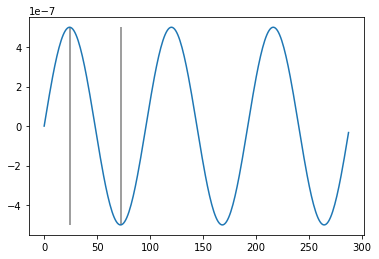

In [7]:
t = onp.linspace(0,287,288)
planet_signal = 0.5e-6*onp.sin(2*np.pi*(1/96)*t)
plt.plot(planet_signal)
plt.vlines([24,72], -5e-7, 5e-7, color = 'grey')

In [24]:
noisy0 = onp.load('shortcycle/bb no zernike/Noisy/Epoch0.npy')
noisy24 = onp.load('shortcycle/bb no zernike/Noisy/Epoch24.npy')
noisy72 = onp.load('shortcycle/bb no zernike/Noisy/Epoch72.npy')

In [25]:
anchors0x, anchors0y = get_really_stable_anchors(noisy0)
anchors24x, anchors24y = get_really_stable_anchors(noisy24)
anchors72x, anchors72y = get_really_stable_anchors(noisy72)


print(onp.shape(anchors0x))
print(onp.shape(anchors24x))
print(onp.shape(anchors72x))

(50, 11)
(50, 11)
(50, 11)


(50,)
(50, 11)
(50,)


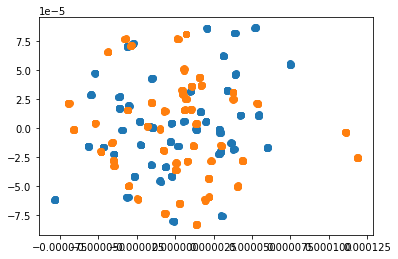

In [26]:
#plt.scatter(anchors0x, anchors0y)
print(onp.shape(anchors24x[:,0]))
print(onp.shape(anchors24x-anchors0x))
plt.scatter(anchors24x-anchors0x, anchors24y-anchors0y)
plt.scatter(anchors72x-anchors0x, anchors72y-anchors0y)

test = onp.sum(anchors24x, axis = 1)
print(onp.shape(test))

In [12]:
data = fits.open('shortcycle/bb no zernike/Epoch0.fits')
standard_image = data[1].data
standard_image = make_noisy(standard_image, 1.8e12)

standard_anchorsx, standard_anchorsy = get_really_stable_anchors(standard_image)
standard_anchorsx = standard_anchorsx[:,0]#onp.sum(standard_anchorsx, axis = 1)/11
standard_anchorsy = standard_anchorsy[:,0]#onp.sum(standard_anchorsy, axis = 1)/11
print(onp.shape(standard_anchorsx))
#standard_comx = onp.average(standard_anchorsx)
#standard_comy = onp.average(standard_anchorsy)
standard_anchorsx = onp.delete(standard_anchorsx, 30)  #removes extra point
standard_anchorsy = onp.delete(standard_anchorsy, 30)

distance_vec = onp.zeros(49)

for i in tqdm(range(96)):
    data = fits.open('shortcycle/bb no zernike/Epoch{}.fits'.format(i+1))
    im = data[1].data
    im = make_noisy(im, 1.8e12)
    anchorsx, anchorsy = get_really_stable_anchors(im)
    anchorsx = anchorsx[:,0]
    anchorsy = anchorsy[:,0]
    
    if onp.shape(anchorsx)[0] == 50:
        anchorsx = onp.delete(anchorsx, 30)  #removes extra point
        anchorsy = onp.delete(anchorsy, 30)
#     comx = onp.average(anchorsx)
#     comy = onp.average(anchorsy)
    sign = [onp.sqrt(anchorsx**2 + anchorsy**2) < onp.sqrt(standard_anchorsx**2 + standard_anchorsy**2)]*onp.ones(49)
    minus = onp.ones(49)*-1

    
    distance = onp.sqrt((anchorsx-standard_anchorsx)**2 + (anchorsy - standard_anchorsy)**2)
    distance = minus**sign * distance
    
    distance_vec = onp.vstack((distance_vec, distance))
    
    
print(onp.shape(distance_vec))

(50,)


  0%|          | 0/96 [00:00<?, ?it/s]

(97, 49)


(97,)
(96,)


<ipython-input-13-a27743f68395>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12,4))


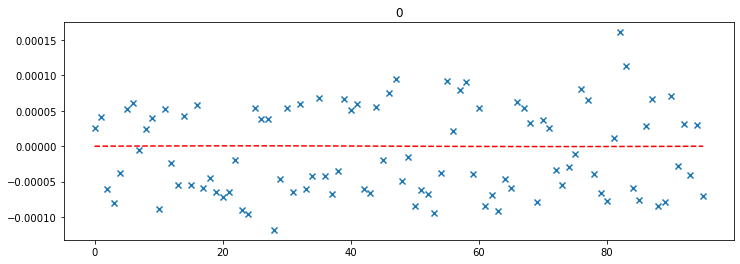

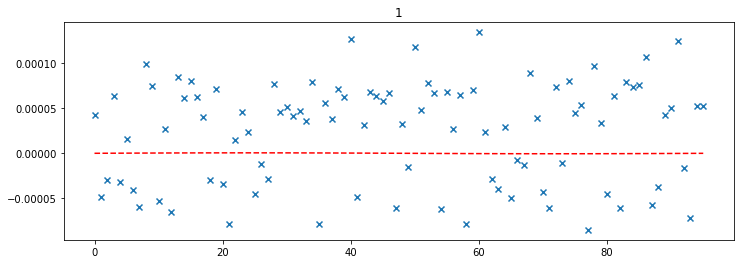

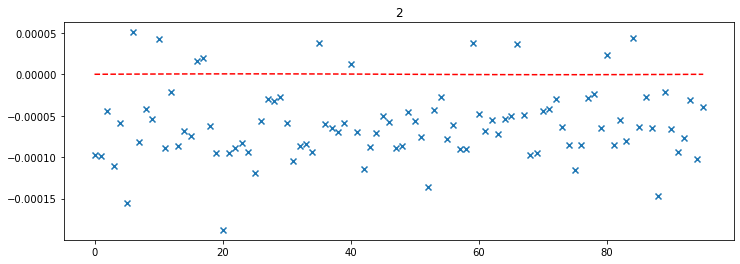

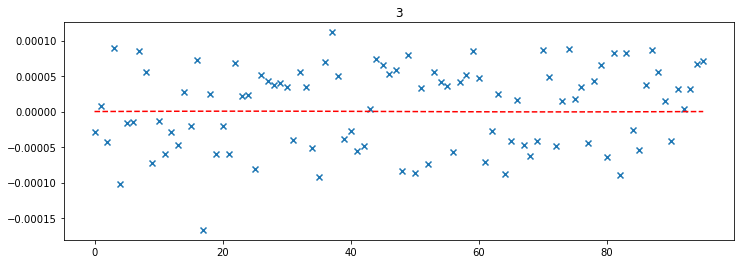

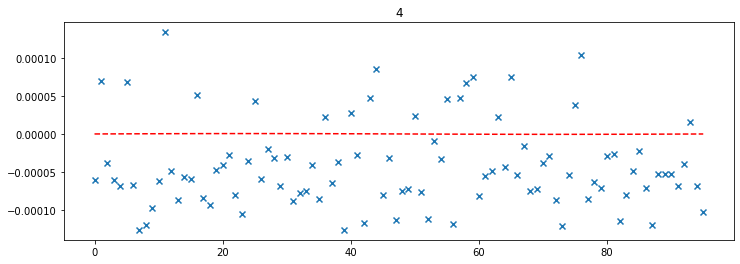

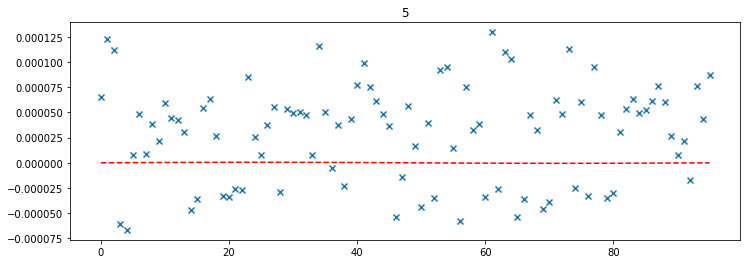

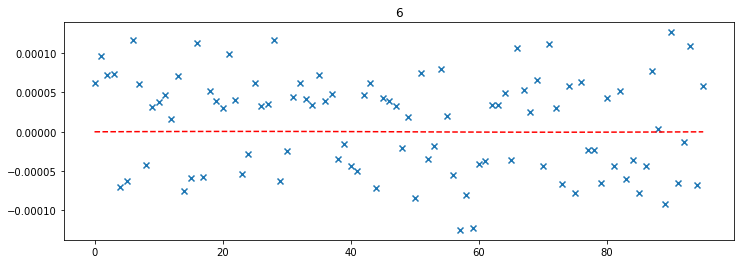

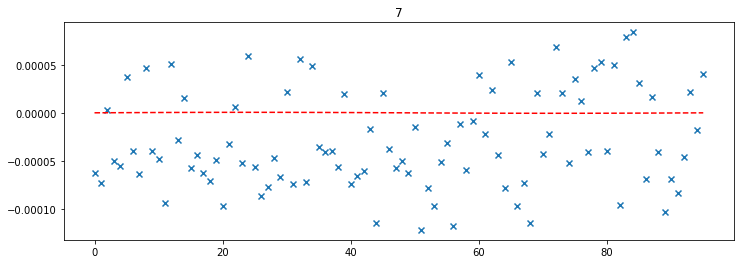

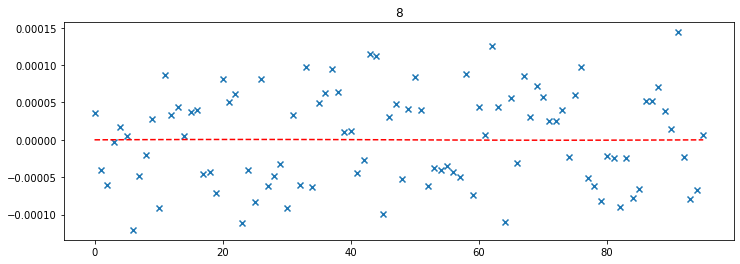

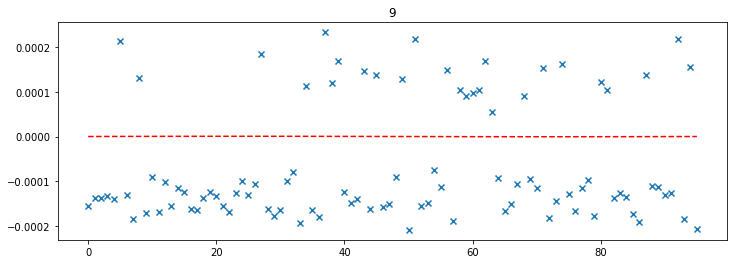

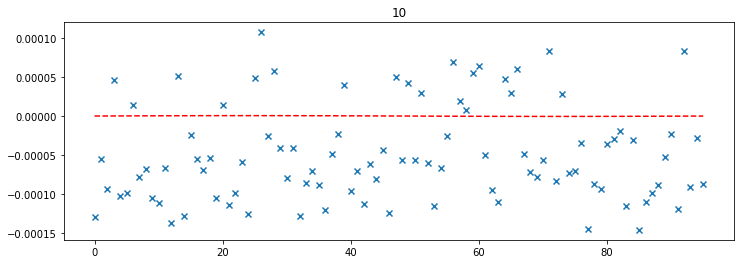

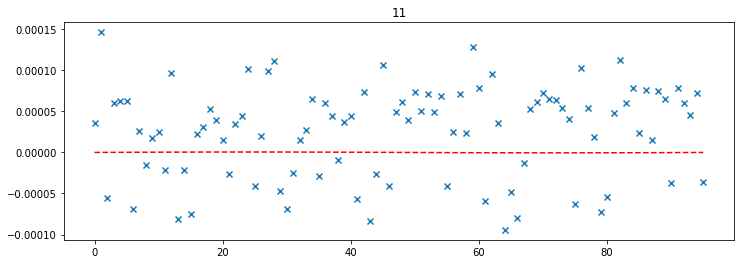

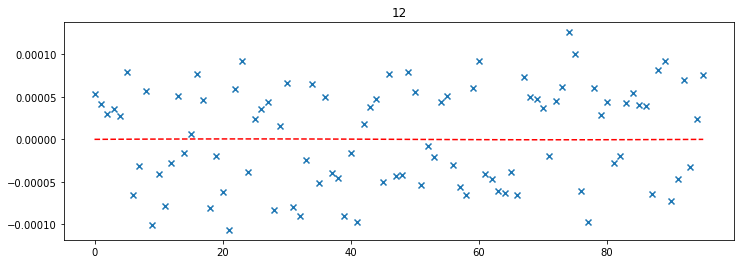

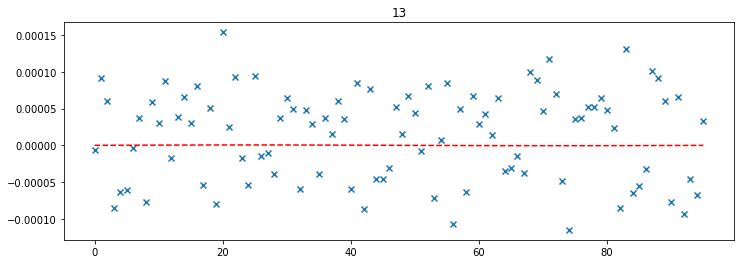

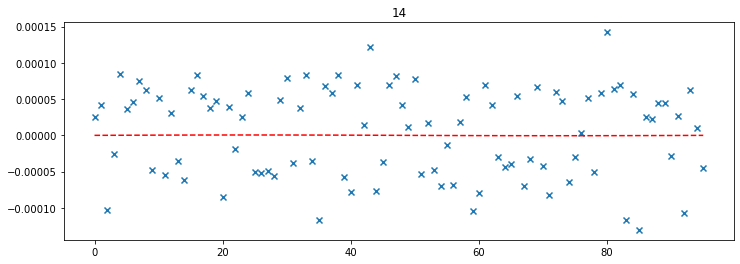

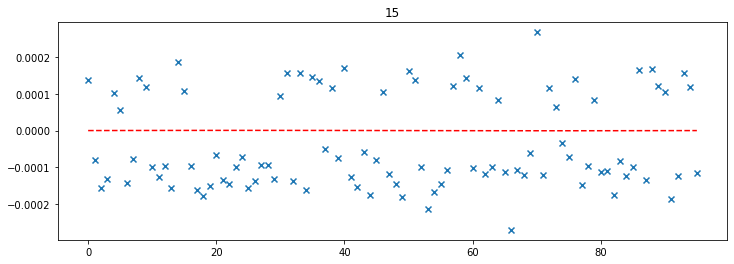

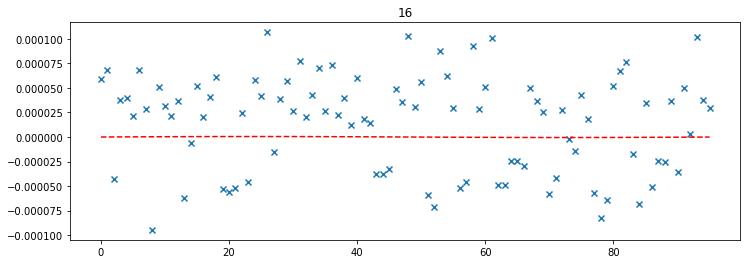

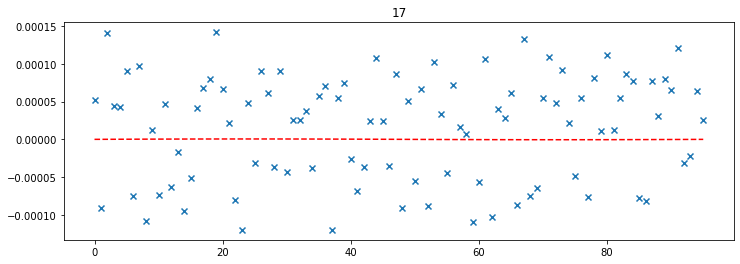

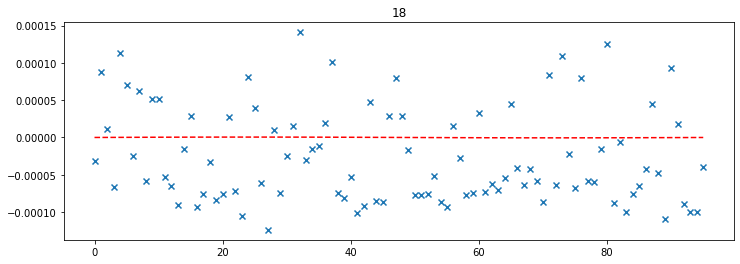

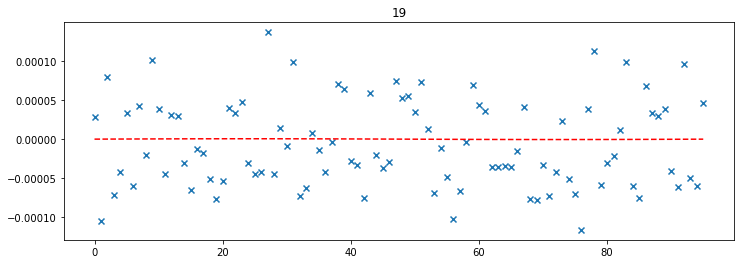

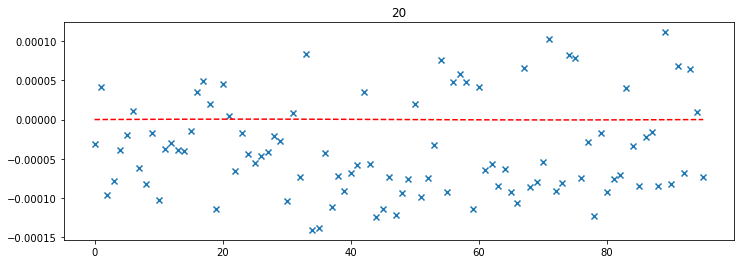

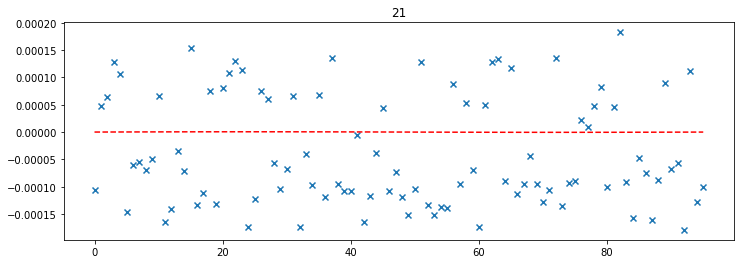

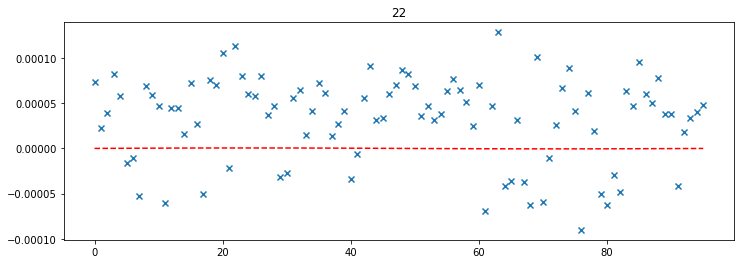

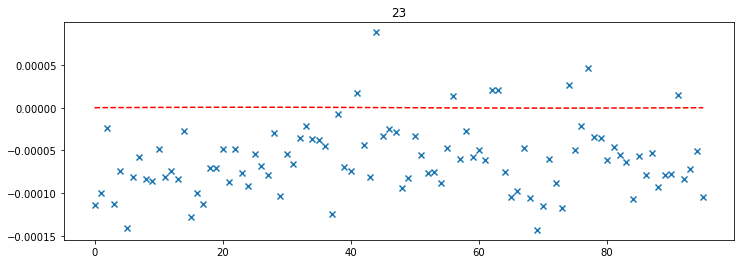

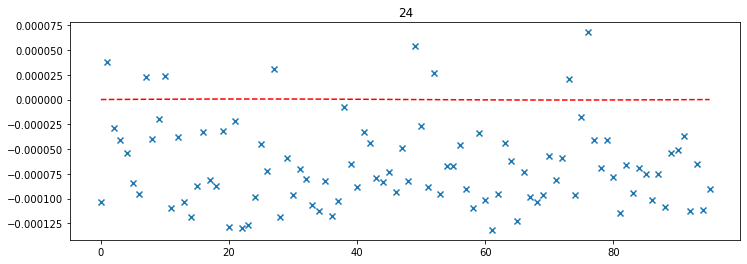

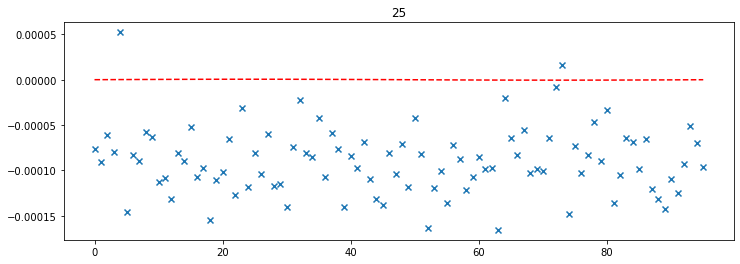

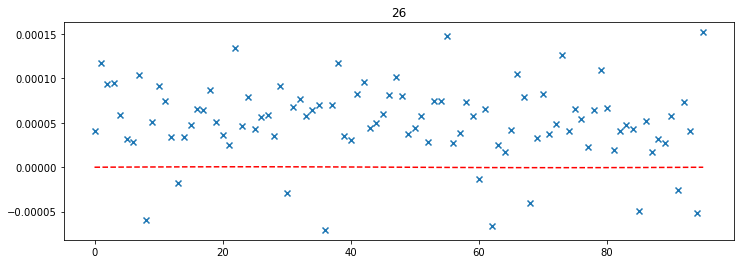

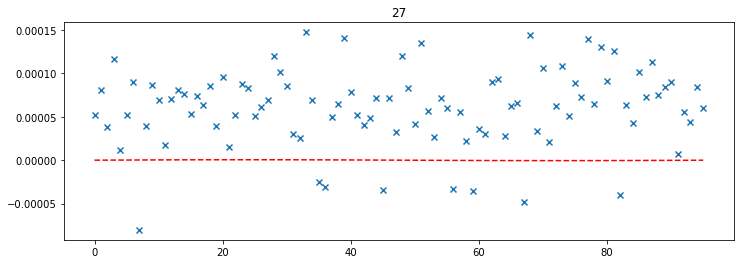

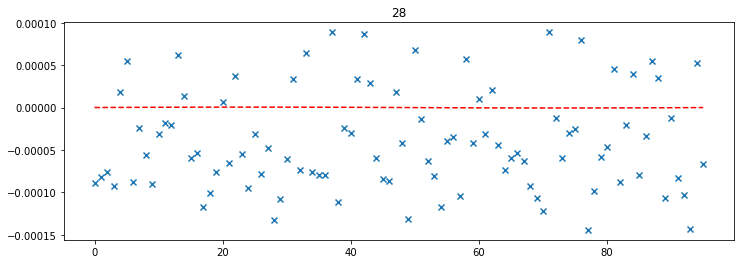

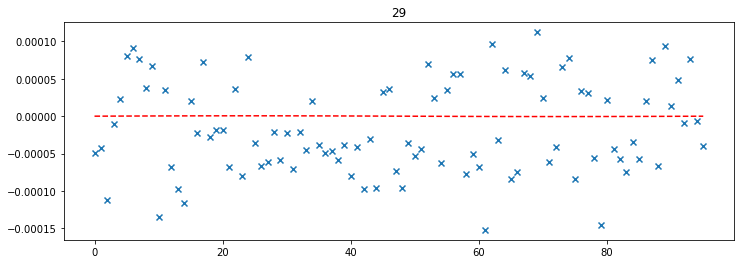

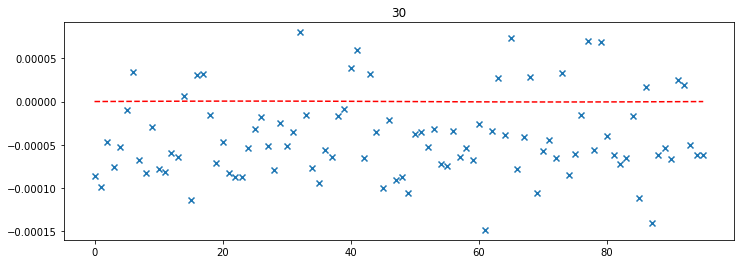

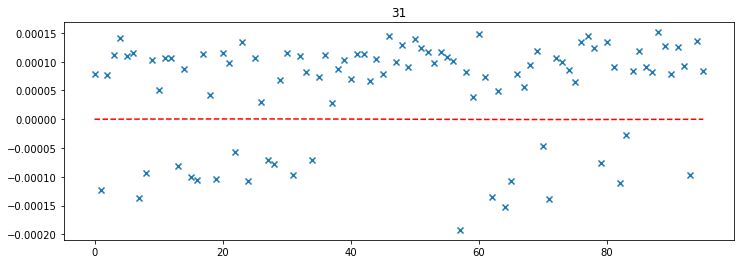

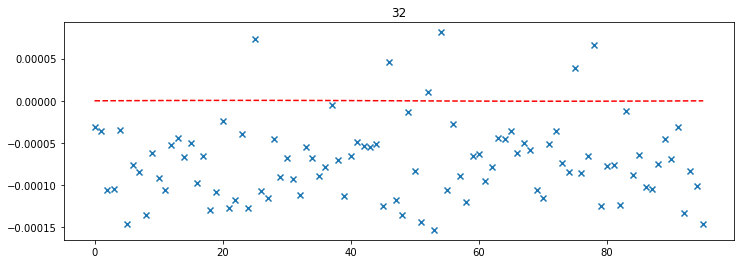

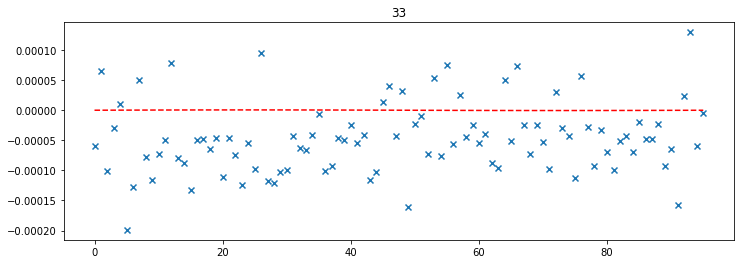

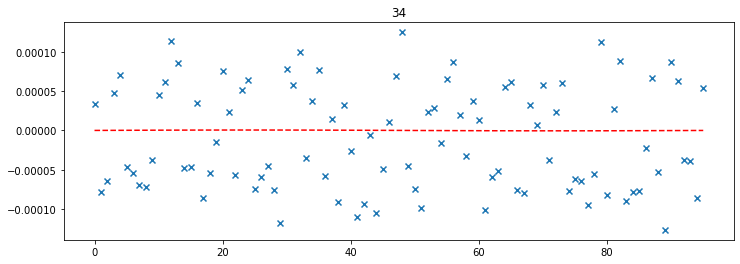

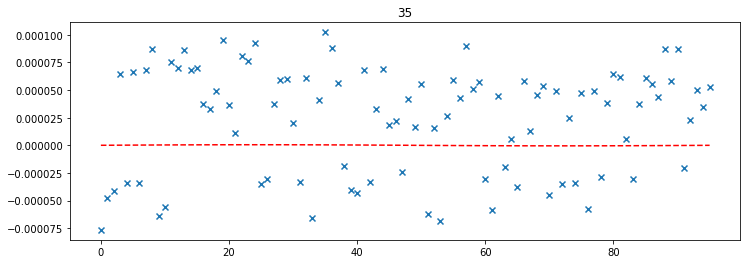

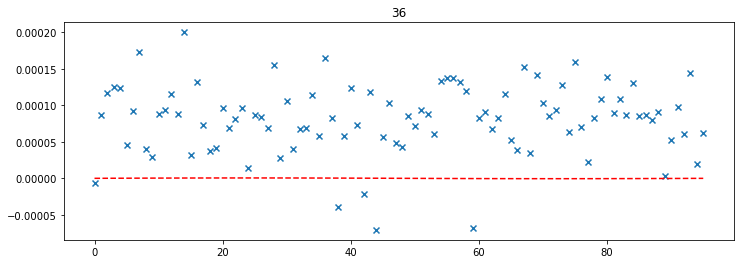

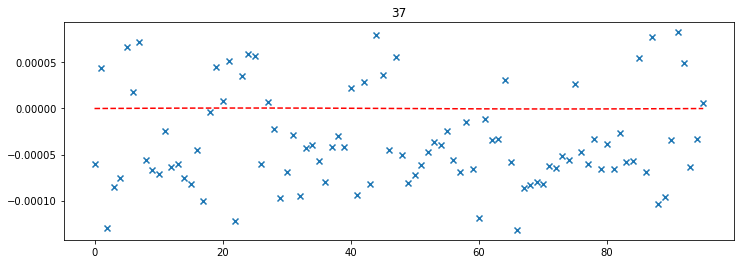

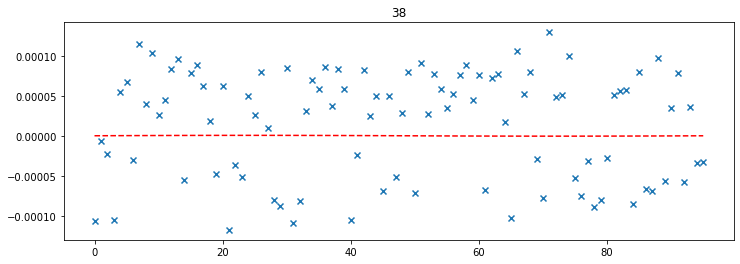

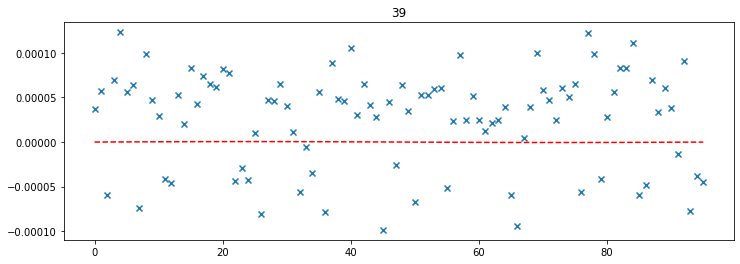

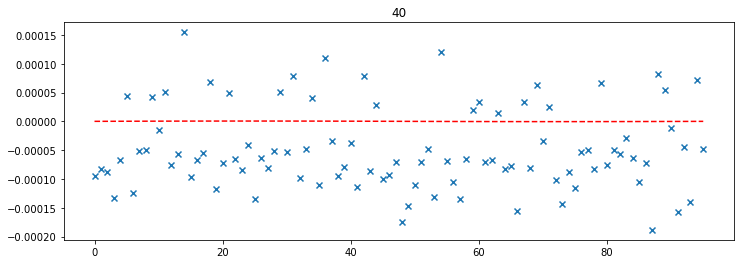

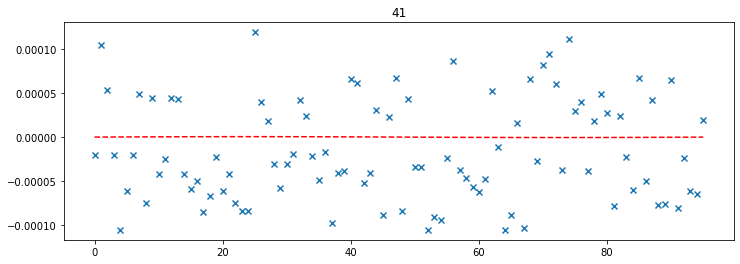

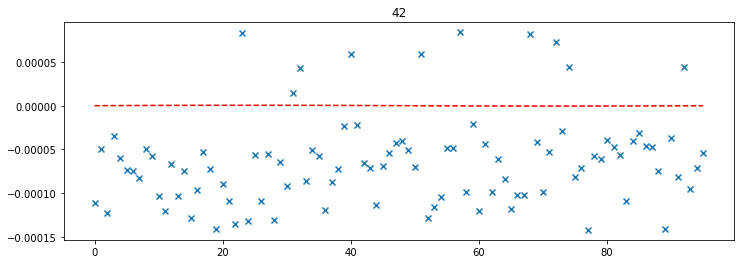

In [ ]:
print(onp.shape(distance_vec[:,0]))
print(onp.shape(range(96)))
#plt.figure(figsize = (12,4))
for i in range(49):
#     res = fit_sin(range(244), distance_vec[1:,i])
#     tt2 = range(244)

    plt.figure(figsize = (12,4))
    #plt.plot(planet_signal[:245], color = 'red', ls = '--')
    plt.plot(planet_signal[:96], ls = '--', color = 'red')

    plt.scatter(range(96), distance_vec[1:,i], marker = 'x')
#     plt.plot(tt2, res["fitfunc"](tt2),ls = '--', label="y fit curve", color = 'black')
    plt.title(i)



  0%|          | 0/96 [00:00<?, ?it/s]

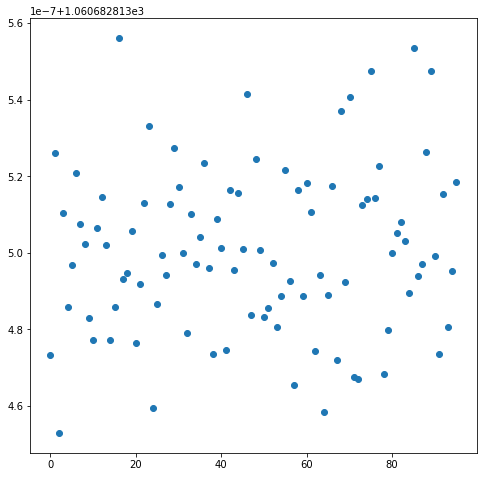

In [39]:
data = fits.open('shortcycle/bb no zernike/Epoch0.fits')
standard_image = data[1].data
standard_image = make_noisy(standard_image, 1.8e19)

x1,y1 = ndimage.center_of_mass(standard_image)

distance_vec = []

for i in tqdm(range(96)): # was 244
    data = fits.open('shortcycle/bb no zernike/Epoch{}.fits'.format(i+1))
    im = data[1].data
    im = make_noisy(im, 1.8e19)
    im = im[750:1250,750:1250]

    
    x,y = ndimage.center_of_mass(im)
    
    dist = onp.sqrt((x-x1)**2 + (y-y1)**2)
    distance_vec = onp.append(distance_vec, dist)
    
plt.figure(figsize = (8,8))
plt.scatter(range(96), distance_vec)

In [ ]:
print(onp.shape(range(244)))
print(onp.shape(distance_vec))


In [ ]:
im = fits.open('shortcycle/bb no zernike/Noisy/noisy_Epoch23.fits')
image = im[1].data
print(onp.max(image*1e9))
print(onp.sum(image)*1e9)

plt.figure(figsize = (8,8))
plt.imshow(image)
plt.colorbar()